# Installing and Importing the Necessary Libraries

In [ ]:
# Installing the necessary libraries with specified versions
!pip install -q openai==1.66.3 \
                tqdm==4.67.0 \
                tiktoken==0.9.0 \
                pypdf==5.4.0 \
                langchain==0.3.20 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.2 \
                langchain-openai==0.3.9 \
                chromadb==0.6.3

**Note:**
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
# Importing the necessary libraries
# Mandatory: Run this AFTER restarting the runtime following the installation step.

import os                   # File paths, environment variables
import json                 # JSON handling
import time                 # Timing utilities
from datetime import datetime

import numpy as np          # Numerical operations (used in RAG similarity search)
import pandas as pd         # DataFrame loading and manipulation
from tqdm import tqdm       # Progress bars for iteration and apply()

# OpenAI-compatible client (used to call Gemini models via Generative Language API)
from openai import OpenAI

# Tokenizer utilities (for token-aware chunking)
import tiktoken

# PDF parsing (extract text from HR policy PDFs)
import pypdf

# LangChain utilities for text splitting and PDF loading
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFDirectoryLoader

# LangChain document structure (stores text chunks + metadata)
from langchain_core.documents import Document

# LangChain/OpenAI embedding wrapper
from langchain_openai import OpenAIEmbeddings

# Chroma integration via LangChain
from langchain_chroma import Chroma

# ChromaDB vector database (stores embeddings for retrieval)
import chromadb

# Reduce excessive Chroma logs
import logging
logging.getLogger("chromadb").setLevel(logging.CRITICAL)

print("All libraries imported successfully.")

All libraries imported successfully.


# **<font color=blue> Setting up the Gemini API key (Colab Secrets) and the client**

## How to get a Gemini API key from Google AI Studio and import it into Colab


1. Click on the `Key icon` in the left sidebar in Colab. There, you will find a dropdown related to **Gemini API keys**. Click on it, and it will reveal two options: *‘Import key from Google AI Studio’* and *‘Manage keys in Google AI Studio.’* Select the first option, **Import key from Google AI Studio**

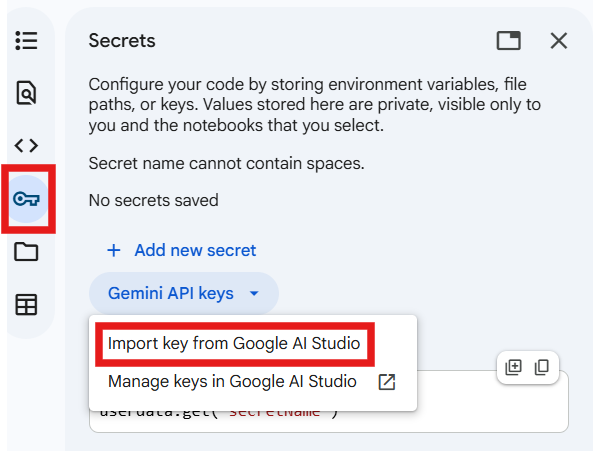

2. After clicking, a text box will appear saying **“No keys found.”** In that box, you will see a description along with a link: `Create your first key in Google AI Studio`. Click on this link, and it will take you to the Google AI Studio page.



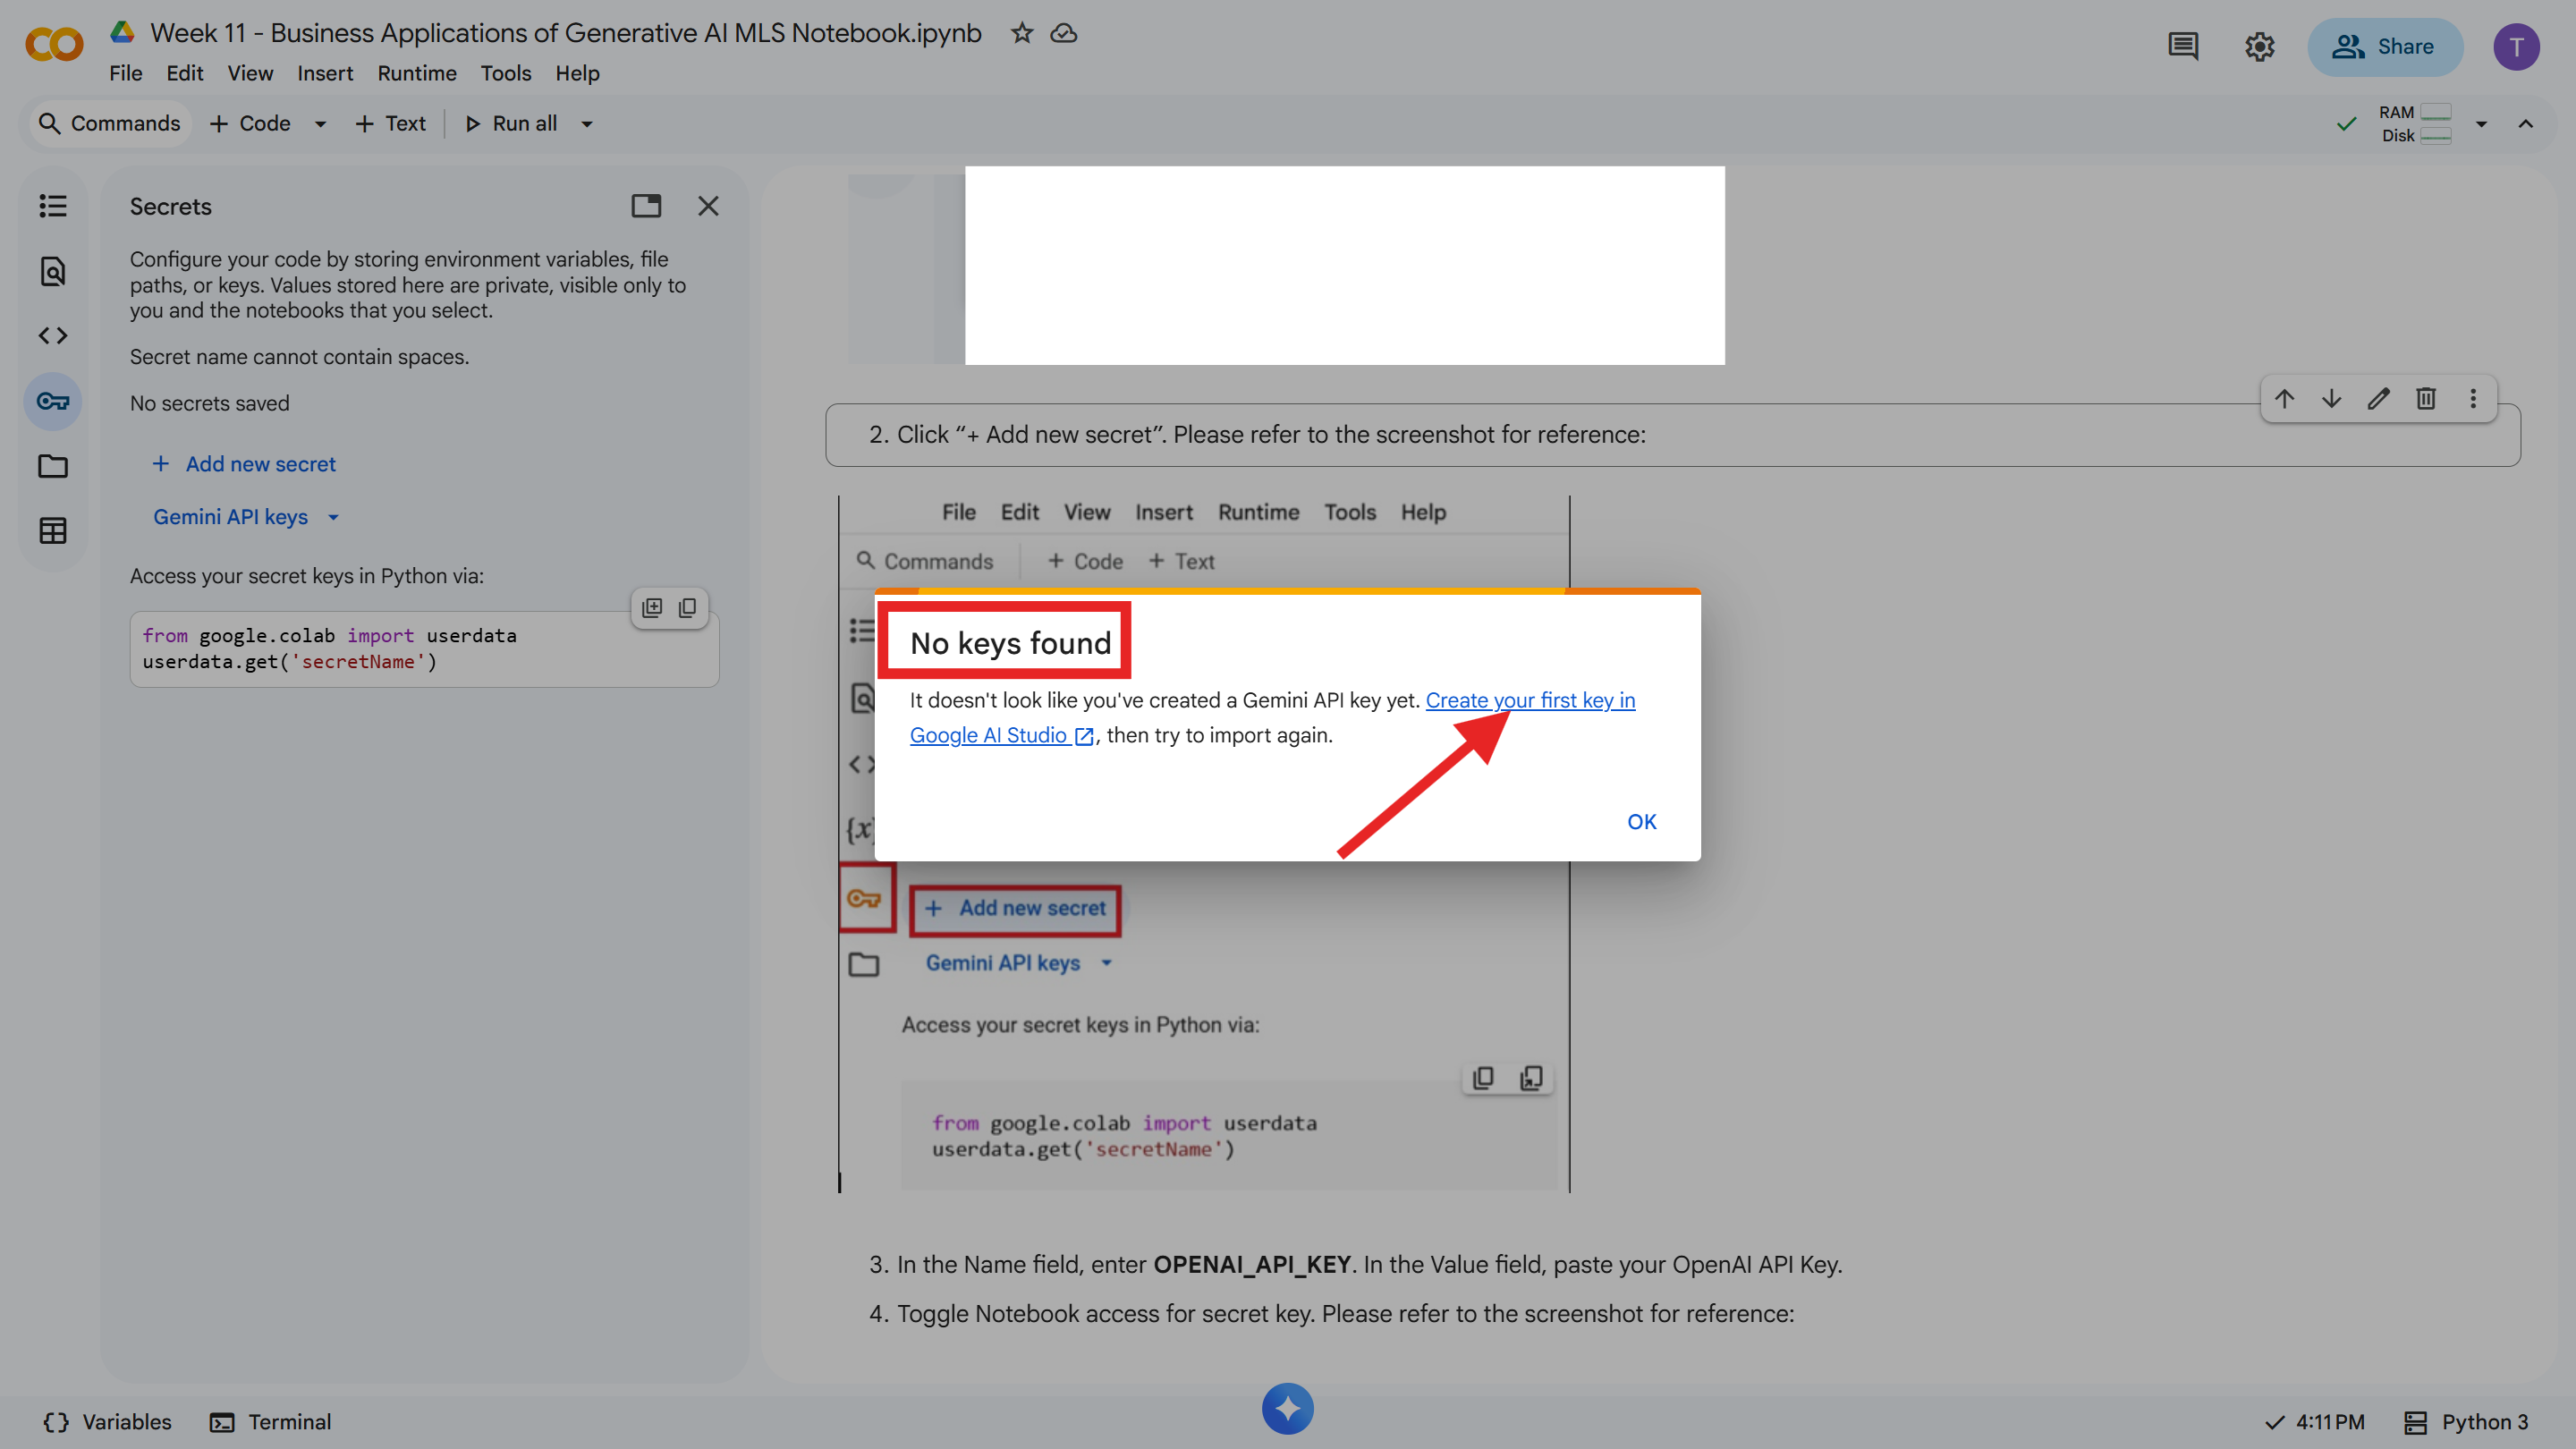

3. If you have not signed up for Google AI Studio yet, please sign up first. After signing in, on the UI you will find an option called **“API keys.”** Click on it.

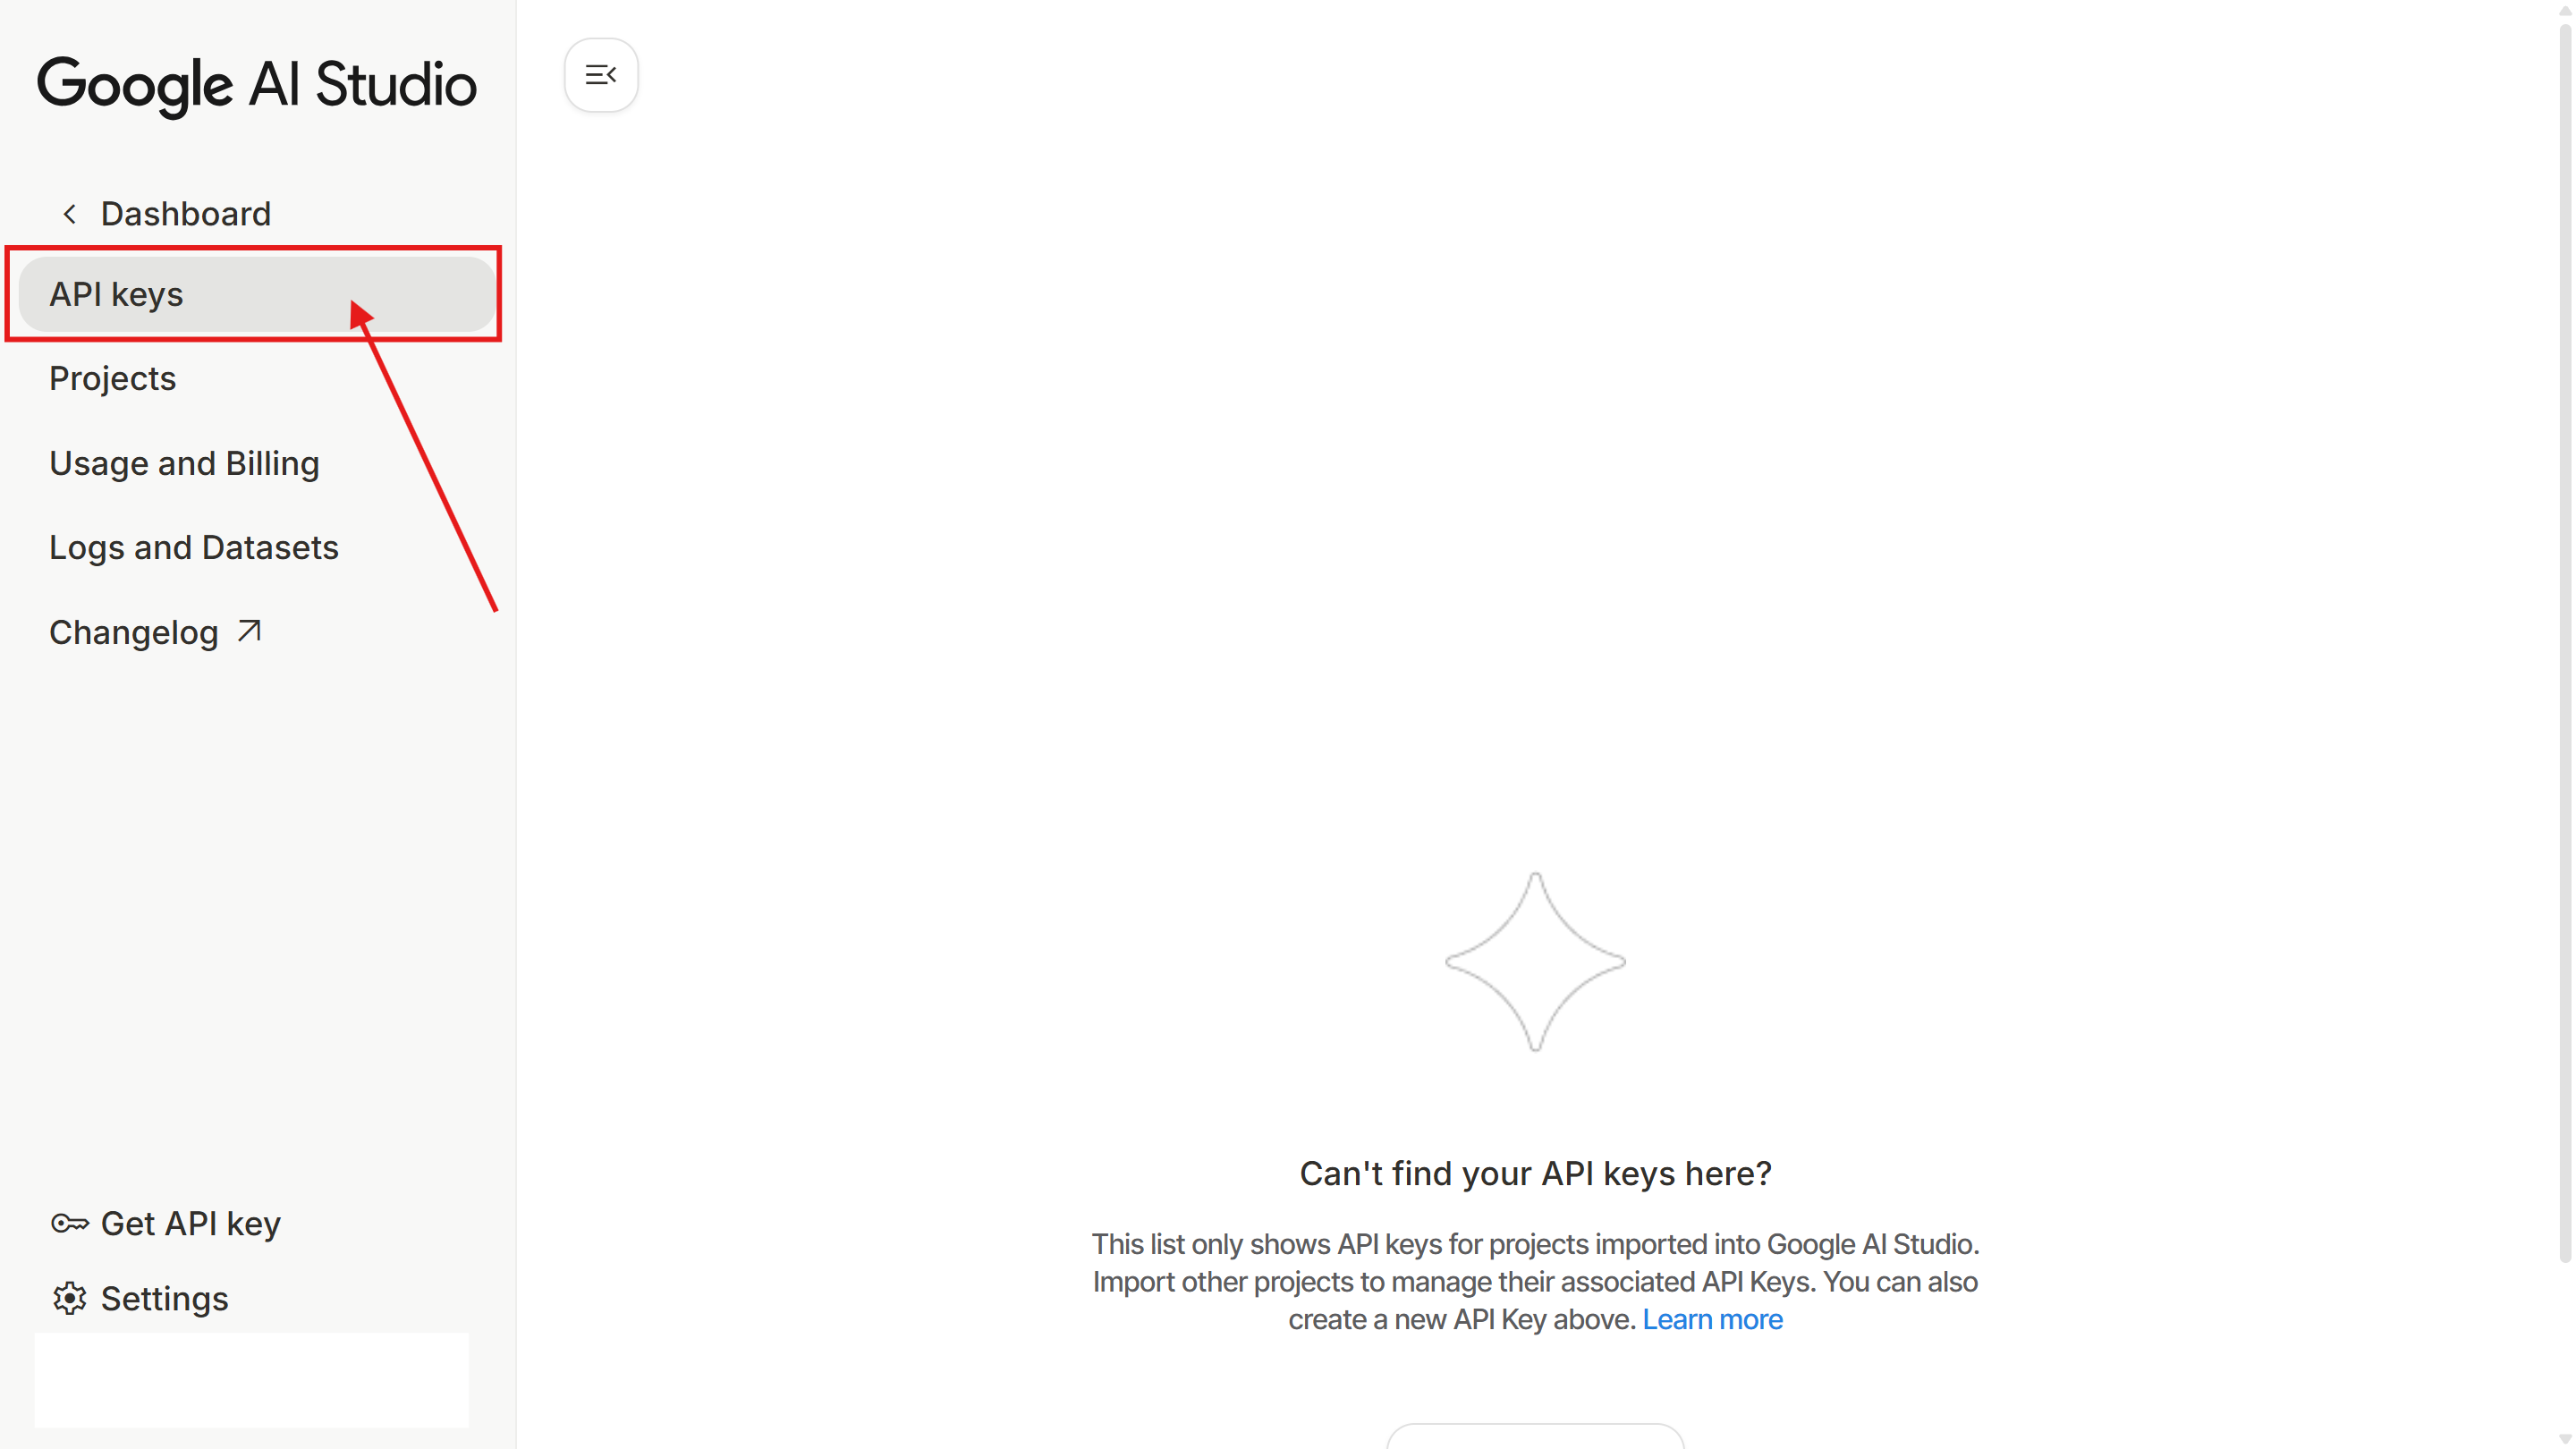

4. You will see a default API key already generated. Ignore that—we will create a new one. On the top, you will find an option to **create a new API key**. Click on it.

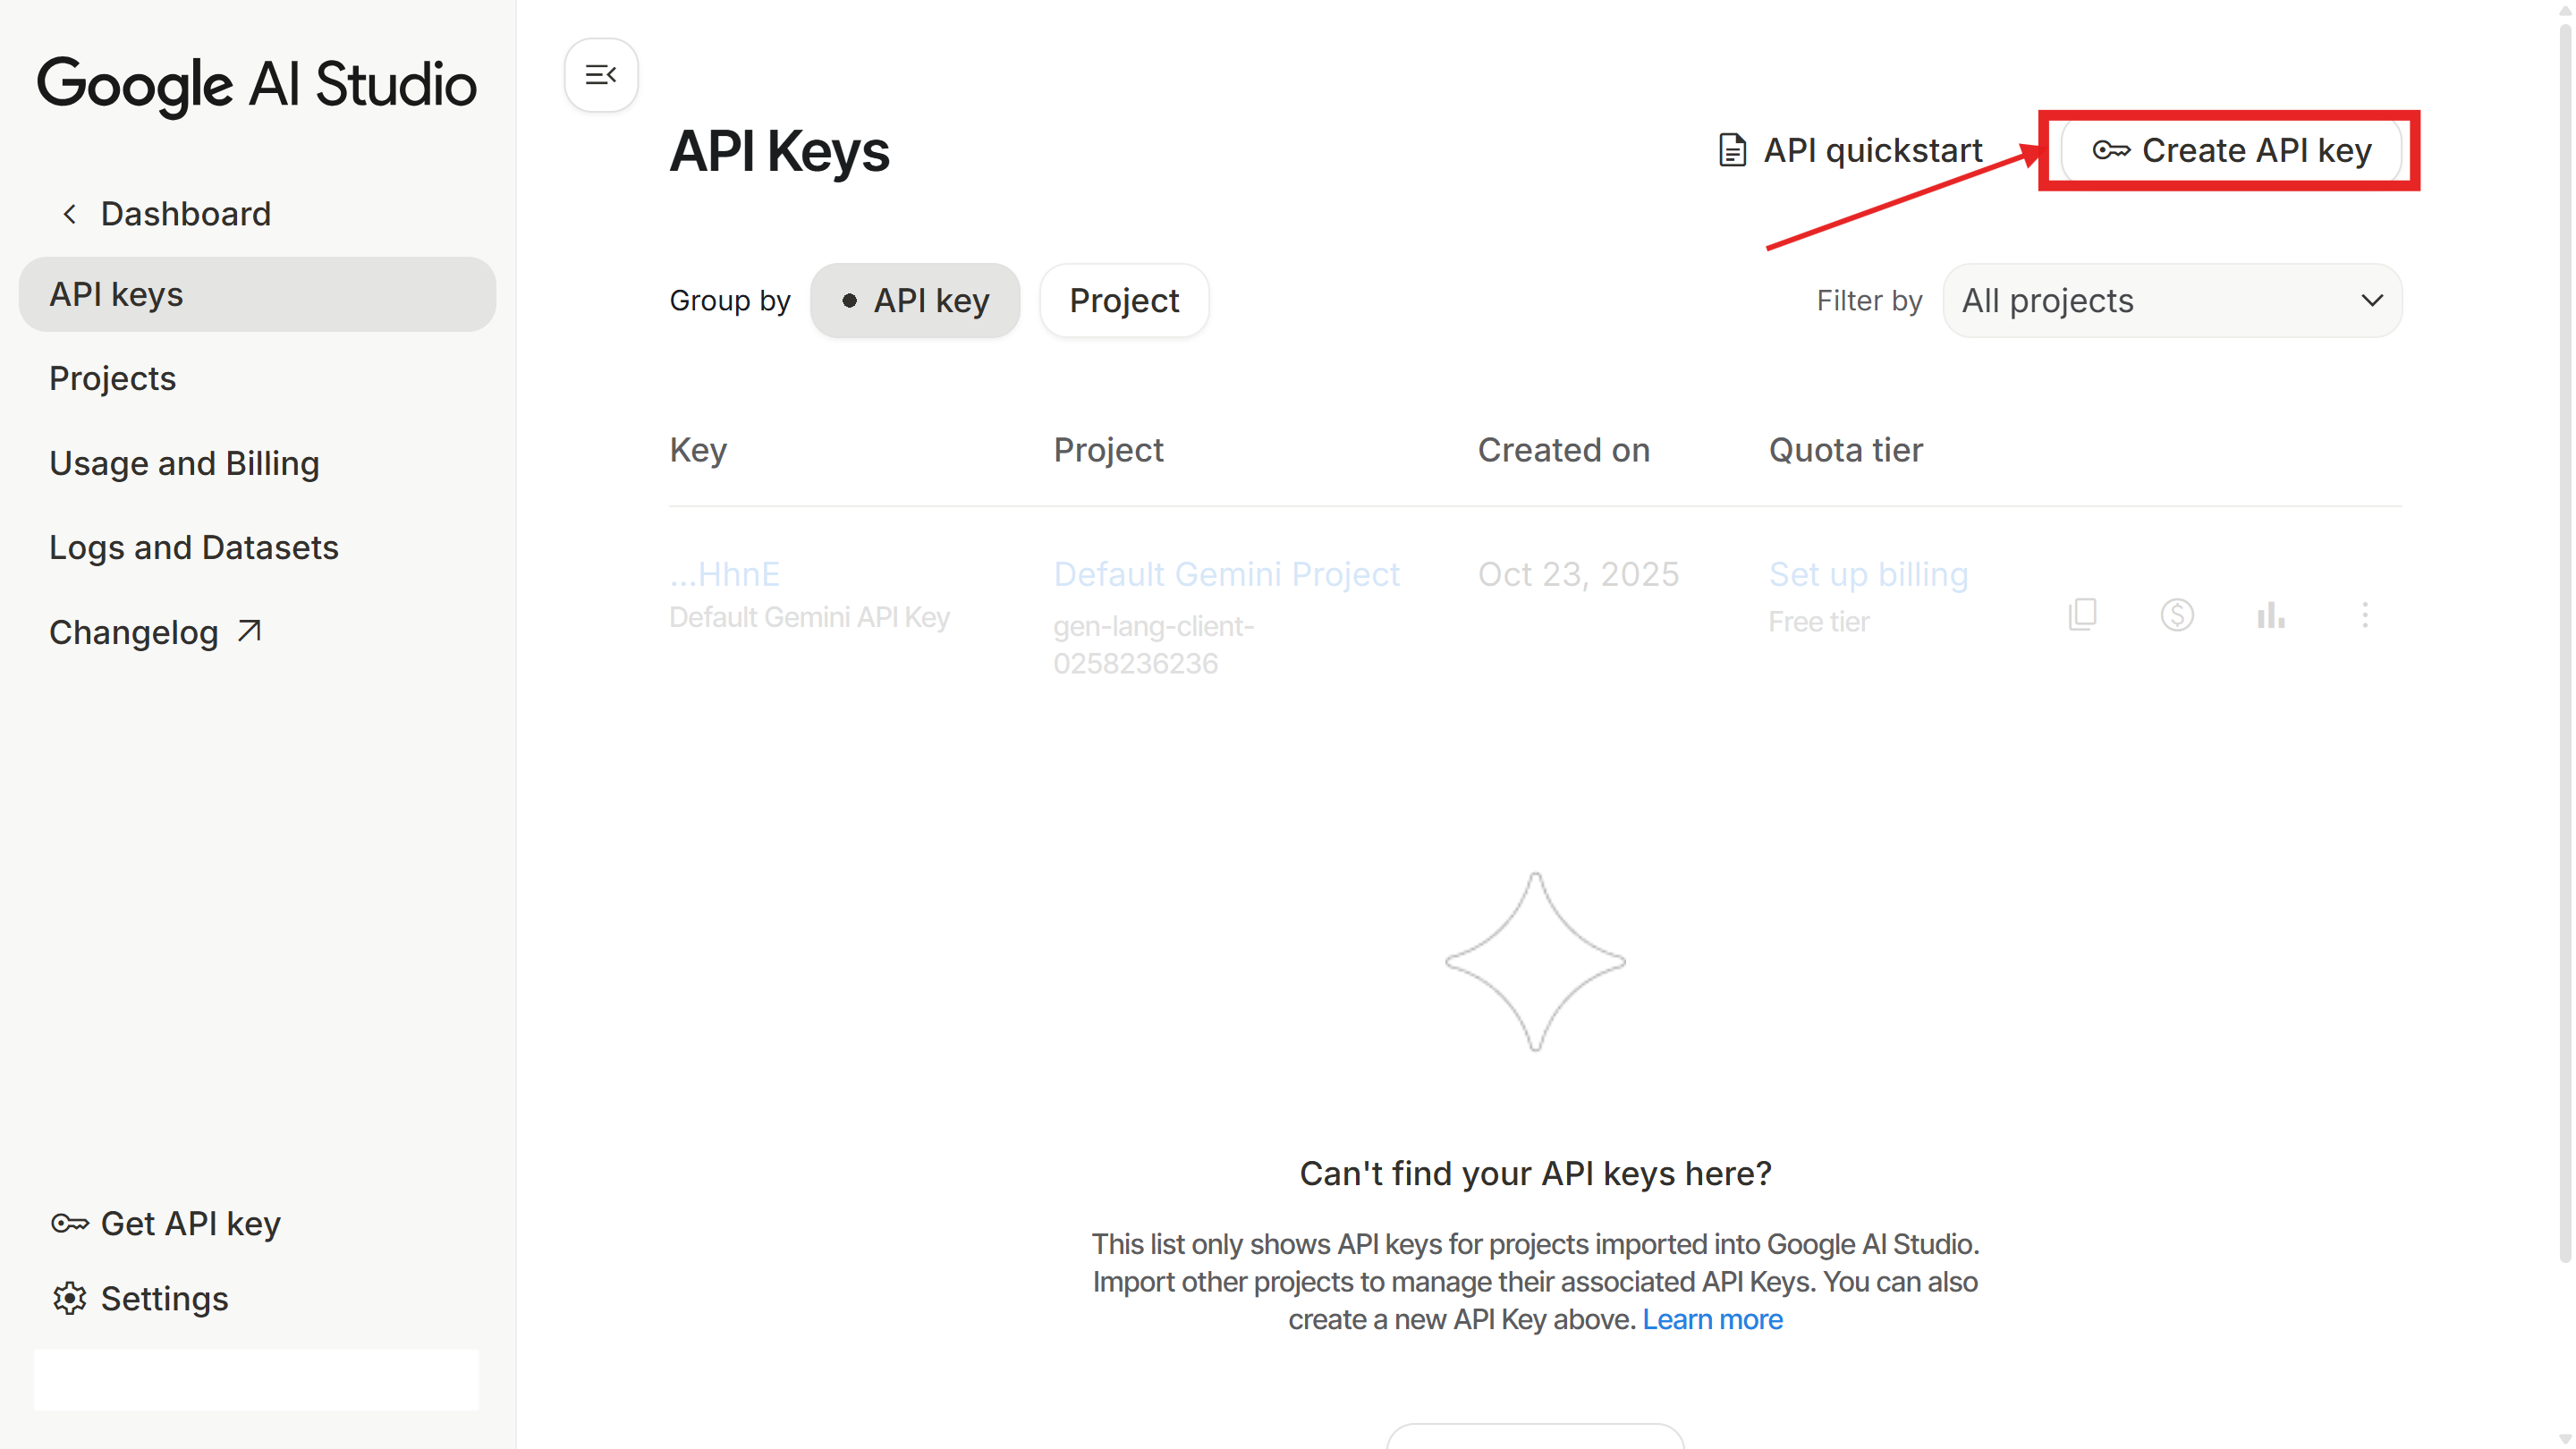

5. A box will pop up asking you to configure your key details. Name your key **“Business Application of Gen AI MLS.”** For the project, choose **“Default Gemini Project,”** and then click on Create Key.

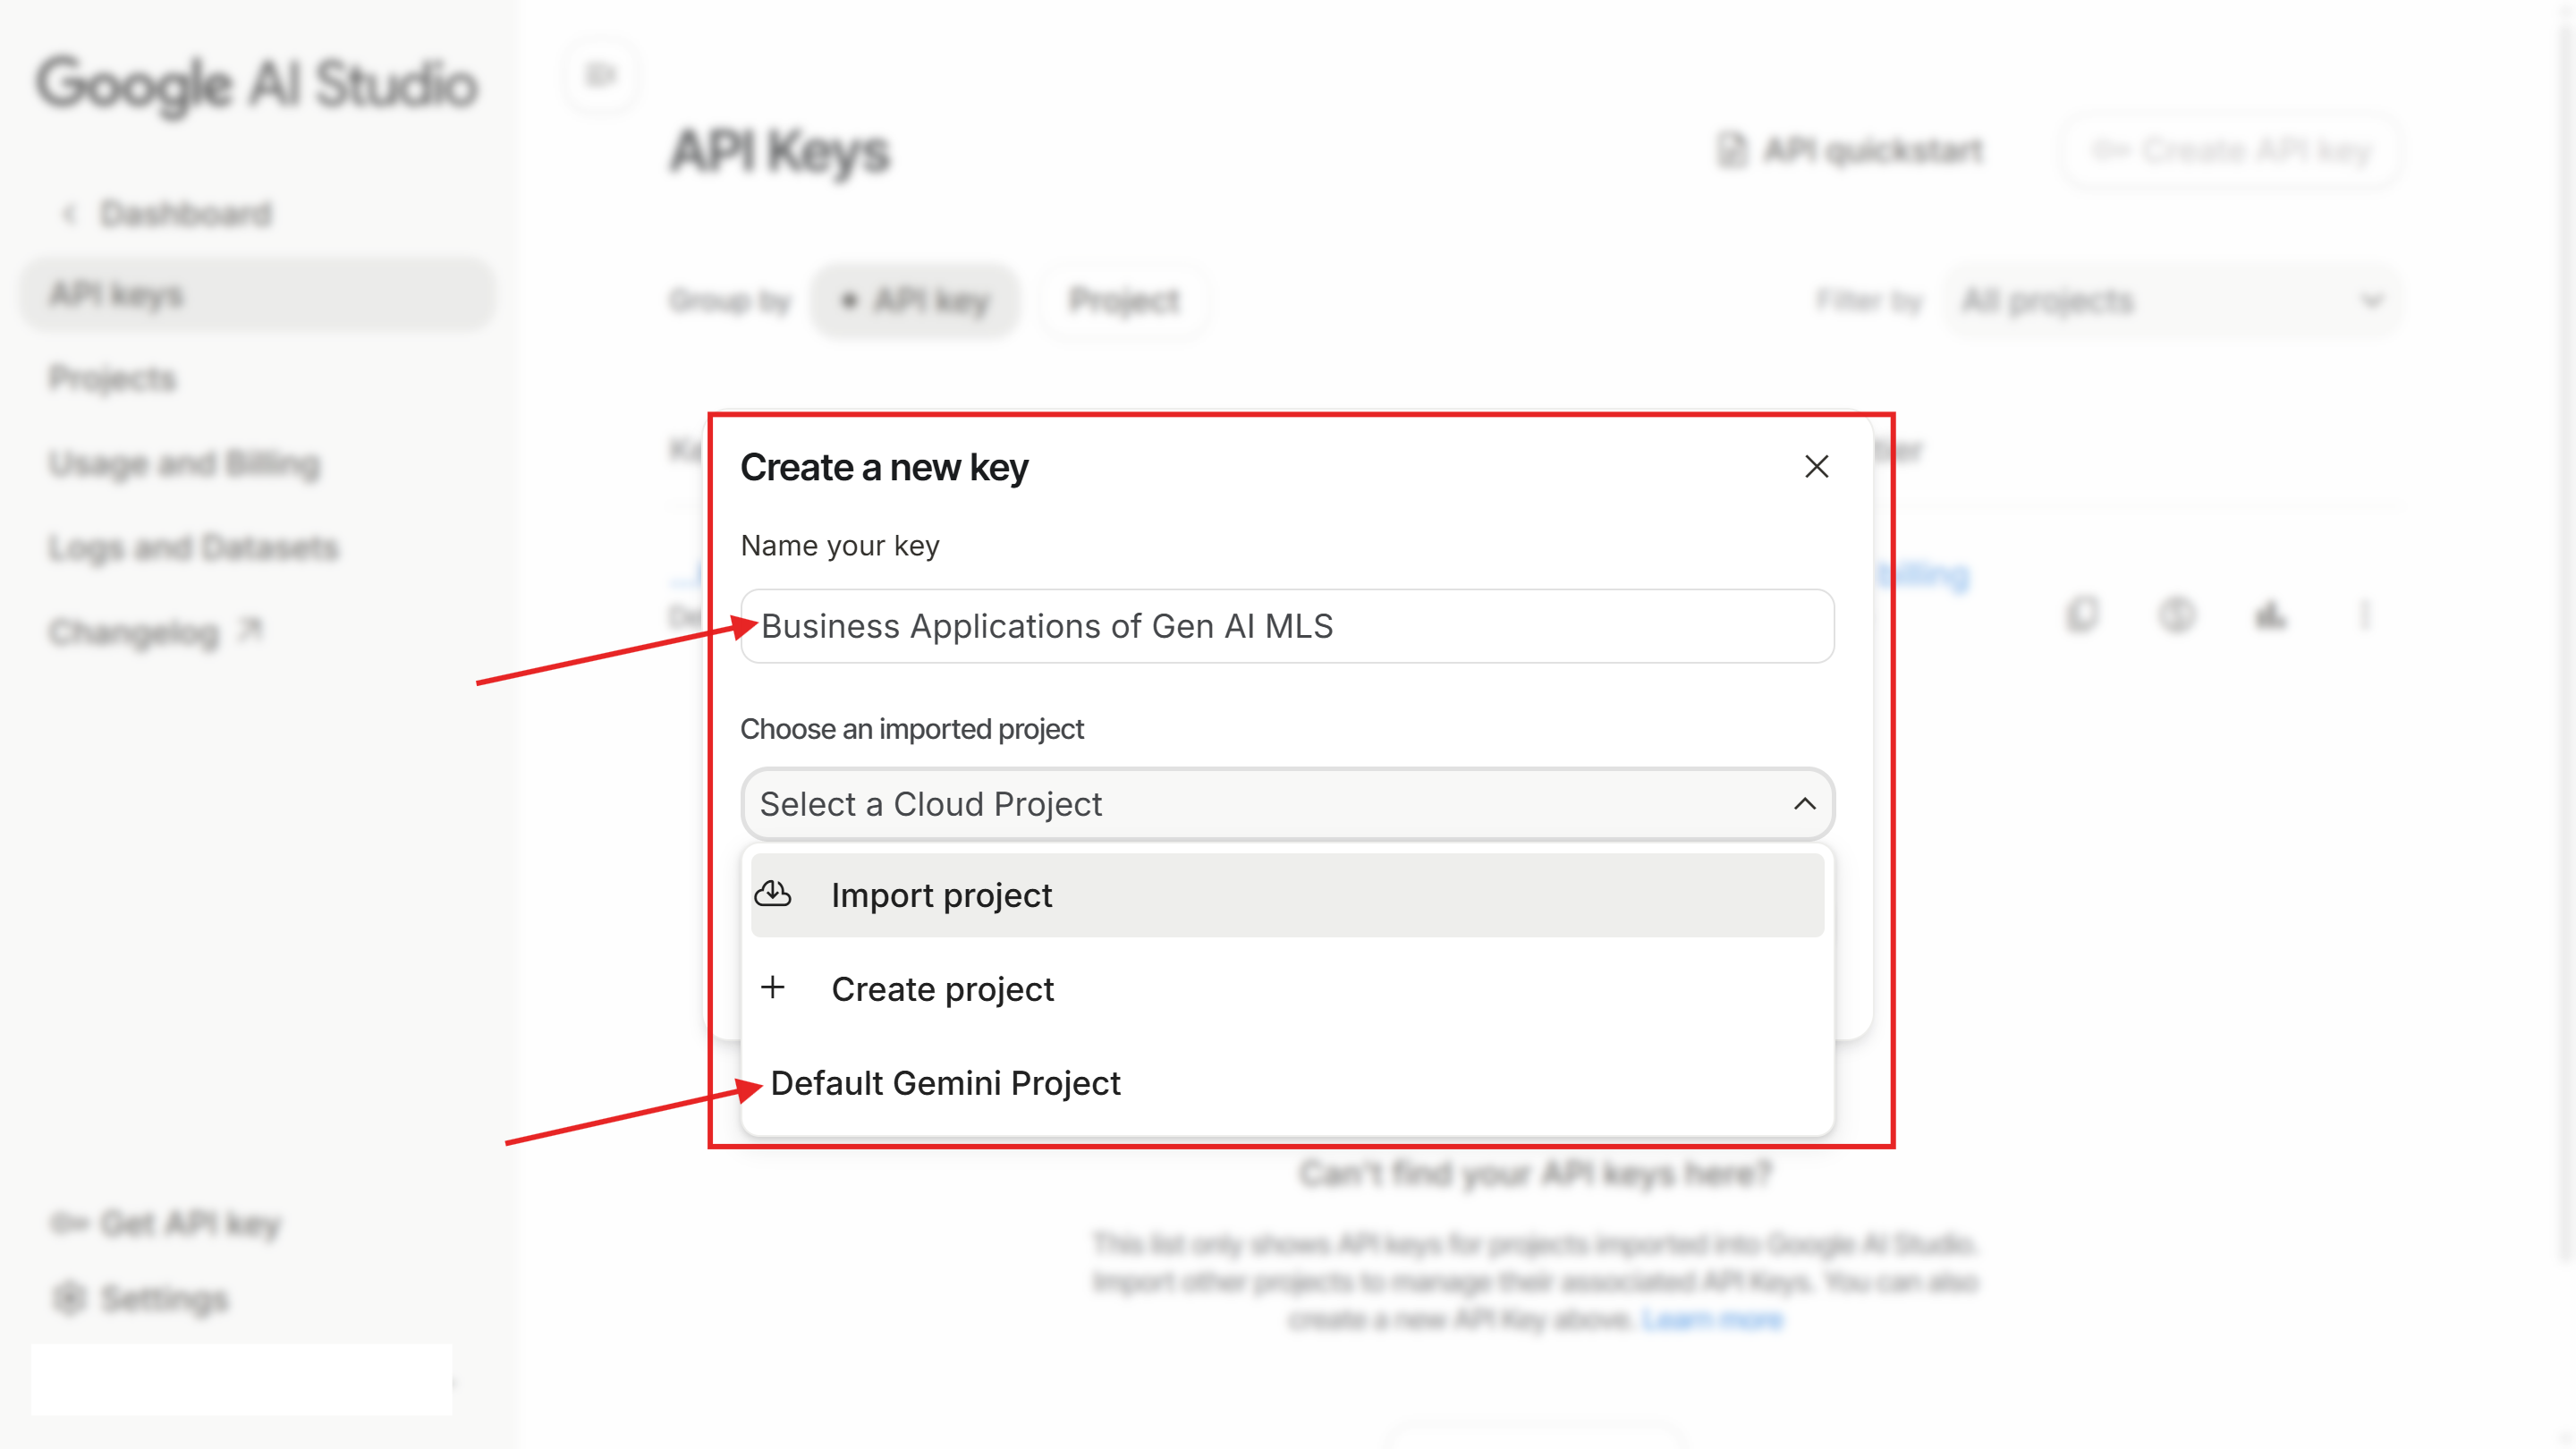

6. Once the key is generated, copy it and return to your Colab window. There, click on **“Add new secret”**. In the Name field, enter `GEMINI_API_KEY`. In the Value field, paste your Gemini API key.

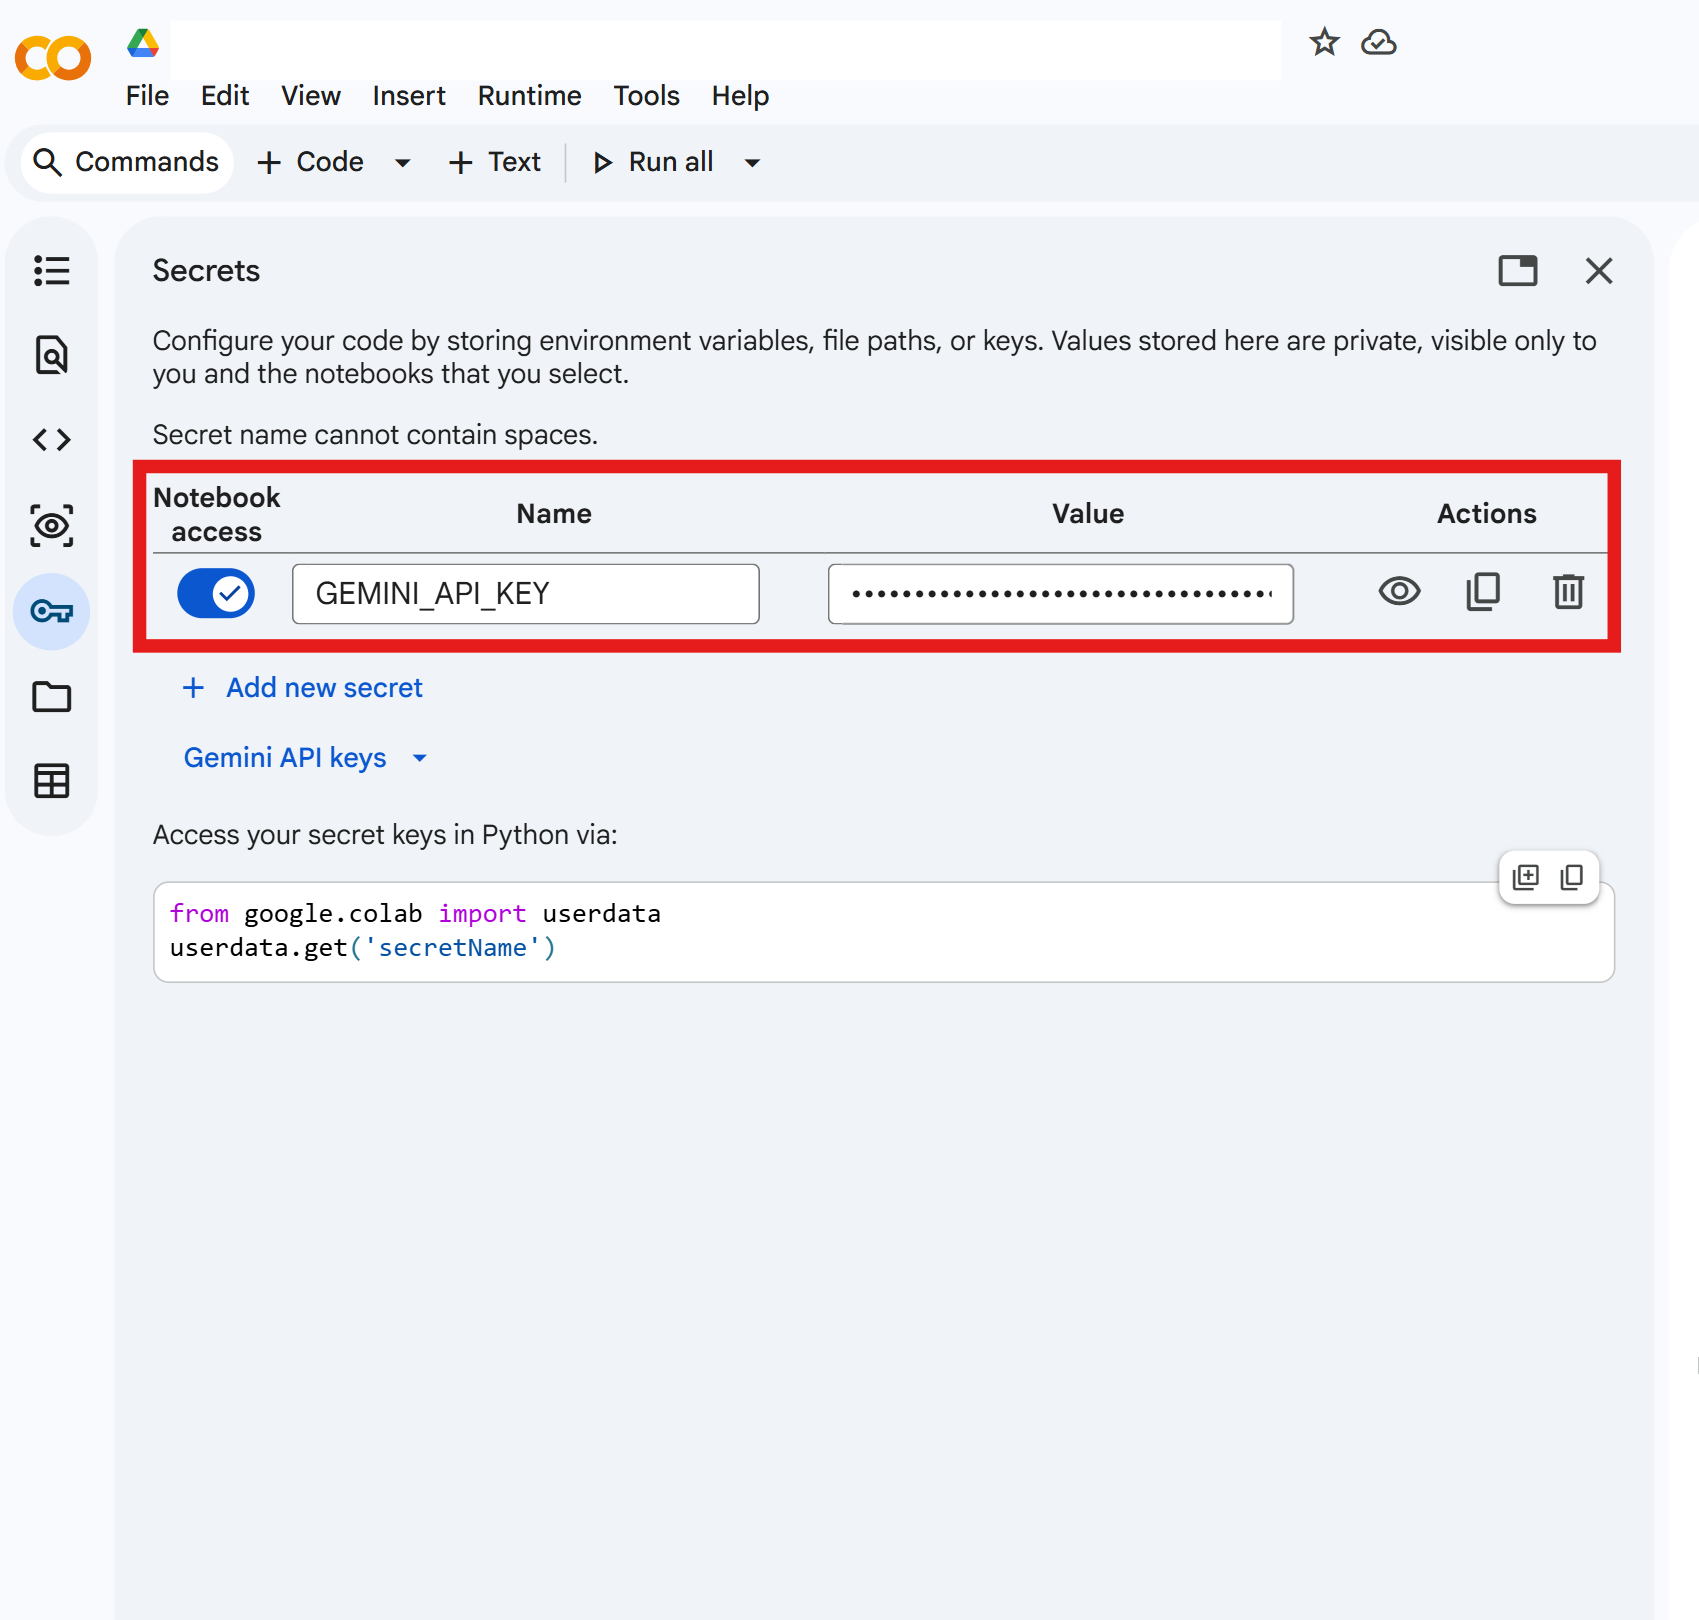

## Setting up the Gemini Client


- This cell reads the Gemini API key from Colab Secrets *(secret name: GEMINI_API_KEY)* and creates an OpenAI-compatible client targeting Google's Generative Language endpoint.
- If you run locally, use the commented local-fallback code below instead.

In [ ]:
# -----------------------------
# Setting up the Gemini Client (Colab-only)
# -----------------------------

from google.colab import userdata   # Colab helper to read secrets
from openai import OpenAI            # OpenAI-compatible client for Gemini

# Read the Gemini API key from Colab Secrets (secret name must match exactly)
gemini_api_key = userdata.get("GEMINI_API_KEY")   # set this secret in Colab as described above

# Instantiate the OpenAI-compatible client pointing to Google's Generative Language endpoint
client = OpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

print("Gemini client created. You can now use `client` to call embeddings and chat endpoints.")

Gemini client created. You can now use `client` to call embeddings and chat endpoints.


In [ ]:
# -----------------------------
# Local fallback: use environment variable GEMINI_API_KEY
# -----------------------------
# Uncomment and run this block if you're running outside Colab and have set the env var.

# import os
# from openai import OpenAI
#
# gemini_api_key = os.environ.get("GEMINI_API_KEY")
# client = OpenAI(
#     api_key=gemini_api_key,
#     base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
# )
# print("Gemini client created (local).")

## Sanity Check: Validate the Gemini Client Setup

- List available models (shows first few)
- Create a tiny embedding
- Do a simple chat completion and print the assistant text

In [ ]:
print("=== Sanity Check Started ===\n")

# 1. List available models
print("Available Models (sample):")
models = client.models.list()
model_ids = [m.id for m in models.data]
print(model_ids[:10], "\n")



# 2. Embedding test
print("Embedding test (gemini-embedding-001)...")
emb_resp = client.embeddings.create(
    model="gemini-embedding-001",
    input="This is a test embedding."
)
emb_vector = emb_resp.data[0].embedding
print("Embedding generated. Vector length:", len(emb_vector), "\n")



# 3. Chat completion test
print("Chat completion test (gemini-2.5-flash)...")
chat_resp = client.chat.completions.create(
    model="gemini-2.5-flash",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Explain to me how AI works in one short sentence."}
    ],
)

# Print the assistant reply text
assistant_text = chat_resp.choices[0].message.content
print("Assistant reply:\n", assistant_text, "\n")

print("=== Sanity Check Completed ===")

=== Sanity Check Started ===

Available Models (sample):
['models/embedding-gecko-001', 'models/gemini-2.5-flash', 'models/gemini-2.5-pro', 'models/gemini-2.0-flash-exp', 'models/gemini-2.0-flash', 'models/gemini-2.0-flash-001', 'models/gemini-2.0-flash-exp-image-generation', 'models/gemini-2.0-flash-lite-001', 'models/gemini-2.0-flash-lite', 'models/gemini-2.0-flash-lite-preview-02-05'] 

Embedding test (gemini-embedding-001)...
Embedding generated. Vector length: 3072 

Chat completion test (gemini-2.5-flash)...
Assistant reply:
 AI enables machines to learn from data and perform tasks typically requiring human intelligence. 

=== Sanity Check Completed ===


# Case Study 1: Hotel Guest Review Classification (Text → Label)

## Problem Statement

### Business Context

In the hospitality industry, maintaining a high level of guest satisfaction is critical for brand reputation, repeat bookings, and positive online ratings. A mid-sized hotel chain receives a large volume of guest feedback every day through emails, chat support, post-stay surveys, and online travel platforms. Each message contains valuable insights about the guest experience, from room cleanliness to staff service and hotel facilities.

However, reviewing and sorting this feedback manually is time-consuming and inconsistent. Front Desk and Guest Experience teams often spend hours reading through comments to identify the issue and determine which department should handle it. As guest volume increases, this manual process leads to delayed responses, overlooked problems, and missed opportunities to improve service quality.

To enhance guest satisfaction and streamline operations, the hotel wants to improve how feedback is processed, categorised, and acted upon. Automating the review-labelling process will allow hotel teams to quickly identify top issues, address complaints faster, and make data-driven improvements to elevate the overall guest experience.

### Objective

As an AI Engineer, your task is to design a code-based AI workflow that automatically classifies guest reviews into predefined categories to support operational decision-making. This automated classification pipeline should:

- Assign each guest review to the most relevant category for faster issue routing  
- Reduce manual effort involved in reading, sorting, and tagging reviews  
- Provide consistent and structured insights into recurring guest issues  
- Enable hotel teams to respond more quickly and maintain higher service quality  

By implementing this automated classification system, the hotel aims to modernise its feedback-handling process, reduce the turnaround time for corrective actions, and enhance the overall guest experience across all properties.

### Data Description: Hotel Guest Review Data for Classification

This dataset contains guest reviews collected after their hotel stay. Each review expresses feedback related to one primary aspect of the guest experience, and the objective is to classify each comment into a single category.

#### I. About this Data
- Contains 30 real-style guest reviews collected post-stay  
- Each review highlights one dominant theme related to the stay  
- Can be used for manual labelling, AI-based classification, or training a no-code workflow  
- Reviews should be classified into one of the following categories  

#### II. Categories to Predict
- **Cleanliness:** feedback about room or hotel cleanliness  
- **Service:** staff behaviour, helpfulness, attitude, or support experience  
- **Amenities:** facilities such as gym, pool, breakfast, Wi-Fi, AC, parking, etc.  
- **Location:** feedback on surroundings, accessibility, convenience, or neighbourhood  
- **Booking/Reservations:** issues with booking, check-in details, payment, or room allocation  
- **Needs human review:** if the review contains multiple unrelated issues or is unclear  

#### III. Data Columns
- **Review_Text:** the guest’s feedback in their own words  
- **Category (to Predict):** the label to be assigned by the AI tool  

### Task Type: Text → Label Classification

Each guest review must be classified into exactly **one** of the following categories:
*Cleanliness, Service, Amenities, Location, Booking/Reservations, Needs human review*

To perform this classification reliably, we will use a **few-shot prompting approach** with Gemini. By providing the model with clear instructions and a small set of labeled examples, the classifier learns the expected output format and applies the same reasoning to new, unseen guest reviews.

**Workflow Overview**

To build this automated classification pipeline, we will follow these steps:

1. Load the hotel guest reviews dataset either from Google Drive or by uploading a CSV file directly into Colab.
2. Construct the prompt, combining a structured system message with a few representative examples to guide the model’s labeling behavior.
3. Implement the classification function that sends each review to the Gemini model and returns exactly one category per record.
4. Apply the classifier across the full dataset, generating a new column called `Predicted_Label` that contains the model’s output for each review.
5. (Optional) Save the enriched dataset for reporting, dashboarding, team workflows, or further analytics.

## 1.1 Load Dataset

### Loading the Hotel Guest Reviews Dataset

We will now load the dataset that contains the hotel guest reviews.  
Each row should include at least one column:

- **Review_Text** — the guest’s feedback in plain text.

You may load the dataset in one of two ways:

1. **OPTION A:** Load from Google Drive  
2. **OPTION B (Recommended):** Manually upload the file into Colab and read it  
   *(We will use **Option B** for this case study.)*

### Option A: Load from Google Drive

#### **<font color=blue> Mounting Google Drive**

The following are the instructions to mount your Google Drive to access and store files (such as vector embeddings in ChromaDB vector database in a .sqlite database)

Step 1:

Import the drive module and Mount Google Drive using the following code
```
from google.colab import drive
drive.mount('/content/drive')
```

Step 2:

Authorize Access

After running the above command, Colab will open a pop-up window to authorize colab to access Google Drive.

Click on the button **Connect to Google Drive**


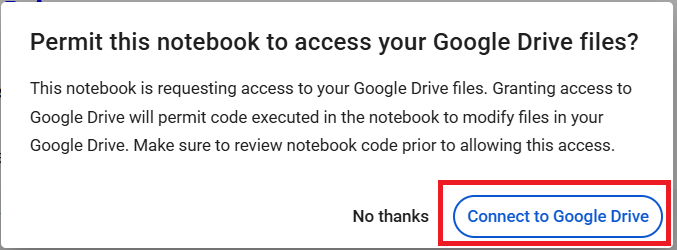

Step 3:

Select the correct email address and click on the **Continue** button to provide the authorization for the reuqired services.

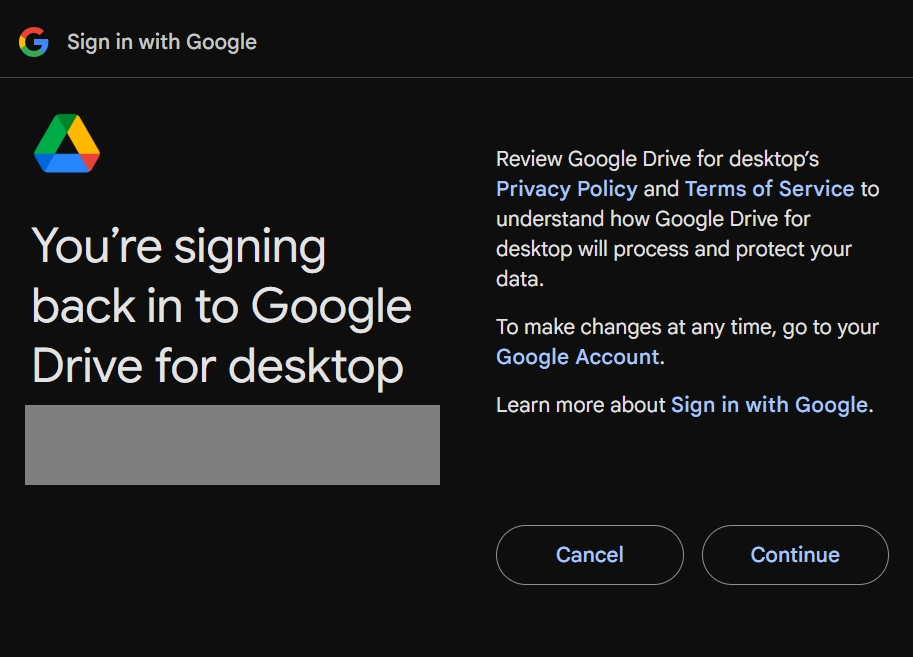

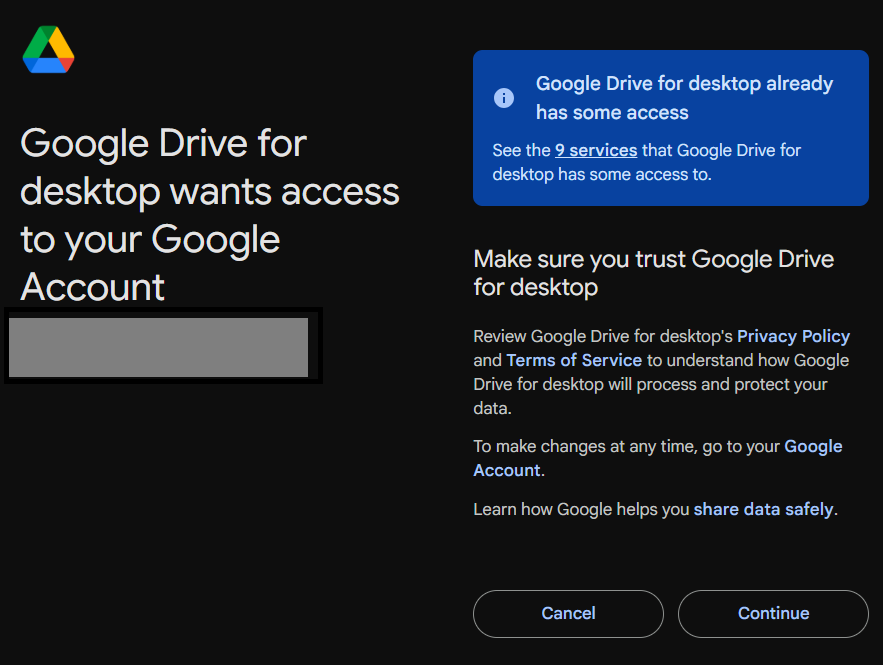

After successful mounting, your Google Drive will be accessible at the following location: `/content/drive/`

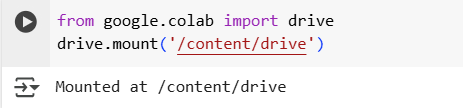

You can now use standard Python commands to access your files:

```
!ls /content/drive/MyDrive/
```

In [ ]:
# Mounting drive to the location
from google.colab import drive
drive.mount('/content/drive')

# To mount a specific location FOLDER_NAME in your Google Drive, uncvomment and run the following code
# drive.mount('/content/drive/MyDrive/<FOLDER_NAME>')

Mounted at /content/drive


#### Read Dataset from Google Drive

In [ ]:
# # -------------------------------
# # OPTION A: Load Dataset from Google Drive
# # -------------------------------
# # Use this option only if your dataset is stored in Google Drive.

# # Update the path below to point to your file in Drive
# # Example: "/content/drive/MyDrive/hotel_reviews/hotel_guest_reviews.csv"
# DATA_PATH = "/content/drive/MyDrive/path_to_your_file/hotel_guest_reviews.csv"  # <-- CHANGE THIS

# df_reviews = pd.read_csv(DATA_PATH)
# print("Dataset loaded from Drive. Shape:", df_reviews.shape)
# df_reviews.head()


### Option B (Recommended): Manually upload the file into Colab and read it

In [ ]:
# OPTION B: Upload dataset manually into Colab

"""
1. In Colab, open the **left sidebar** → click the **Files** icon.
2. Click **Upload** and select your CSV file from your computer.
3. After the file appears in `/content`, load it using the below code.
"""

import pandas as pd

# Replace with the name of the file you uploaded
DATA_PATH = "/content/hotel_guest_reviews.csv"  # <-- CHANGE THIS

df_reviews = pd.read_csv(DATA_PATH)
# df_reviews = pd.read_excel("/content/hotel_guest_reviews.xlsx") # <-- Uncomment if using Excel sheet


print("Shape of the dataset:", df_reviews.shape)
df_reviews.head()

Shape of the dataset: (10, 3)


,S.NO,Review_Text,Category
0,1,Room was spotless and smelled fresh when we ar...,Cleanliness
1,2,Front desk told us our room wasn’t ready even ...,Service
2,3,The gym had no towels and one of the treadmill...,Amenities
3,4,Great location — five minutes from the train s...,Location
4,5,My reservation showed cancelled when I checked...,Booking/Reservations


## 1.2 Prompt Design for Classification (Few-Shot)

In this case study, we use **few-shot prompting**:

- We give the model a clear **system message** defining its role and the allowed labels.
- We provide a few **labeled examples** (review → category) to show the expected behavior.
- Then we send a new, unseen review as the **user message**, and the model responds with **only one label**.

Why few-shot?

- A simple **zero-shot** instruction (just telling the model the label names) may lead to inconsistent outputs.
- By adding **examples**, we:
  - Reduce ambiguity  
  - Show the expected output format  
  - Improve the consistency and accuracy of the classification  

For this notebook, we will directly use a **single, well-crafted few-shot prompt** rather than iterating through zero-shot / one-shot / four-shot variants.

In [ ]:
# -----------------------------
# Updated system message and few-shot examples for Case Study 1
# (No "Needs human review" option — model must always pick one of the five labels)
# -----------------------------

SYSTEM_MESSAGE_CS1 = """
You are a strict hotel guest review classifier. Read the review and return EXACTLY ONE label chosen from:
[Cleanliness, Service, Amenities, Location, Booking/Reservations].

Rules:
- Return exactly one label (one of: Cleanliness, Service, Amenities, Location, Booking/Reservations).
- Return only the label name — no punctuation, no extra words, no explanations.
- Choose the single most relevant label that represents the main issue in the review.
- If the review mentions multiple issues, choose the label that best represents the primary complaint or the item most stressed by the guest.
- Do not return any label other than the five allowed values.
"""

FEW_SHOT_MESSAGES_CS1 = [
    # Cleanliness examples
    {"role": "user", "content": "Room was spotless and smelled fresh when we arrived."},
    {"role": "assistant", "content": "Cleanliness"},

    # Service examples
    {"role": "user", "content": "Front desk told us our room wasn’t ready even though we arrived on time."},
    {"role": "assistant", "content": "Service"},

    # Amenities examples
    {"role": "user", "content": "The gym and pool were closed during our stay and the Wi-Fi kept dropping."},
    {"role": "assistant", "content": "Amenities"},

    # Location examples
    {"role": "user", "content": "Hotel is a ten-minute walk from the city center and close to the train station."},
    {"role": "assistant", "content": "Location"},

    # Booking/Reservations examples
    {"role": "user", "content": "We reserved a queen room but were given two singles and the rate was higher at check-in."},
    {"role": "assistant", "content": "Booking/Reservations"},
]

# Base message list to reuse: system + few-shot
BASE_MESSAGES_CS1 = [{"role": "system", "content": SYSTEM_MESSAGE_CS1}] + FEW_SHOT_MESSAGES_CS1

## 1.3 Define classifier, test, and apply to entire dataset

In this section we:

1. Define the `classify_review()` function which sends a single review to Gemini and returns exactly one label.  
2. Run a quick smoke test on one example review to verify the function works.  
3. Define `classify_review_safe()` as a wrapper that handles missing values and transient errors so the pipeline doesn't stop.  
4. Apply the safe wrapper across the entire dataset (row-by-row) and store the model outputs in a new column, **Predicted_Label**.

In [ ]:
# 1.3.1 Function: classify_review()
def classify_review(review_text: str, model_name: str = "gemini-2.5-flash") -> str:
    """
    Send one hotel review to Gemini and return a single category label.

    Returns one of:
    ['Cleanliness', 'Service', 'Amenities', 'Location',
     'Booking/Reservations']
    """
    # Guardrail: empty / invalid review -> return a conservative default label
    if not isinstance(review_text, str) or not review_text.strip():
        return "Service"

    # Build messages: system + few-shot examples + this review
    messages = BASE_MESSAGES_CS1 + [{"role": "user", "content": review_text}]

    # Call Gemini chat completion
    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0.0,  # deterministic output for classification
        max_tokens=10
    )

    raw_label = response.choices[0].message.content.strip()

    # Normalize and map small variations back to canonical labels
    normalized = raw_label.lower().replace(".", "").strip()
    valid_labels_map = {
        "cleanliness": "Cleanliness",
        "service": "Service",
        "amenities": "Amenities",
        "location": "Location",
        "booking/reservations": "Booking/Reservations",
        "booking / reservations": "Booking/Reservations",
        "booking & reservations": "Booking/Reservations",
    }

    return valid_labels_map.get(normalized, "Service")

In [ ]:
# 1.3.2 Quick smoke test
test_review = "The gym was closed and the pool was under maintenance our entire stay."
print("Test review:", test_review)
print("Predicted label:", classify_review(test_review))

Test review: The gym was closed and the pool was under maintenance our entire stay.
Predicted label: Amenities


### 🚦 Rate Limit Notice (Gemini Free Tier)

Gemini’s free tier allows a maximum of **5 requests per minute** for models such as `gemini-2.5-flash`.

If you exceed this per-minute limit, you may encounter errors like **`quotaExceeded`** or **`rate_limit_exceeded`**.

In addition to the per-minute limit, the Gemini free tier also enforces a **total request cap of 22 requests**. Once this limit is exceeded, you will not be able to make further requests and will receive a quota-related error. To continue beyond this limit, you must upgrade your Google AI Studio project to a higher billing tier (**Tier 1, Tier 2, or Tier 3**).

To ensure our classification pipeline runs smoothly within the free tier, we’ve implemented rate limiting in the code:  
after every **5 API calls**, the script pauses for **60 seconds** before continuing.

For more details on usage and limits, refer to:
- 📘 Official rate limits documentation:  
  https://ai.google.dev/gemini-api/docs/rate-limits#tier-3
- 📊 Google AI Studio usage & rate limits dashboard:  
  https://aistudio.google.com/usage?timeRange=last-28-days&project=gen-lang-client-0258236236&tab=rate-limit

In [ ]:
# 1.3.3 Prepare to run across the dataset
from tqdm import tqdm
tqdm.pandas()  # enable pandas progress_apply()

TEXT_COL = "Review_Text"  # change if your column name differs

# Validate the review text column exists
if TEXT_COL not in df_reviews.columns:
    raise KeyError(
        f"Column '{TEXT_COL}' not found in the dataset. "
        f"Available columns: {list(df_reviews.columns)}"
    )

# Counter to implement rate limiting: 5 requests/minute for free tier
api_call_counter = 0


# 1.3.4 Safe wrapper with rate limiting (5 requests/min for free tier)
def classify_review_safe(review_text: str) -> str:
    """
    Wrapper that:
    - Handles NaN values
    - Catches errors
    - Enforces Gemini free-tier rate limit (5 requests per minute)

    Returns one of:
    ['Cleanliness', 'Service', 'Amenities', 'Location', 'Booking/Reservations']
    """

    global api_call_counter  # track number of API calls

    # Fallback for missing review text
    if pd.isna(review_text):
        return "Service"

    # Rate-limit enforcement
    if api_call_counter > 0 and api_call_counter % 5 == 0:
        print("\n⏳ Rate limit reached: waiting 60 seconds...\n")
        time.sleep(60)
        print("✔ Resuming requests.\n")

    try:
        label = classify_review(review_text)
        api_call_counter += 1
        return label

    except Exception as e:
        print("Error while classifying a review:", str(e))
        return "Service"   # Default fallback label


# 1.3.5 Apply classification with progress bar
df_reviews["Predicted_Label"] = df_reviews[TEXT_COL].progress_apply(classify_review_safe)

# Preview results
df_reviews.head()

 60%|██████    | 6/10 [00:02<00:01,  2.16it/s]


⏳ Rate limit reached: waiting 60 seconds...

✔ Resuming requests.



100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


,S.NO,Review_Text,Category,Predicted_Label
0,1,Room was spotless and smelled fresh when we ar...,Cleanliness,Cleanliness
1,2,Front desk told us our room wasn’t ready even ...,Service,Service
2,3,The gym had no towels and one of the treadmill...,Amenities,Amenities
3,4,Great location — five minutes from the train s...,Location,Location
4,5,My reservation showed cancelled when I checked...,Booking/Reservations,Booking/Reservations


## 1.4 Saving the Labeled Dataset

Finally, we will save the dataset with the new `Predicted_Label` column so that it can be:

- Shared with operations and guest experience teams  
- Used for dashboards and reporting  
- Connected to downstream analytics / prioritization workflows


In [ ]:
OUTPUT_PATH = "hotel_guest_reviews_with_labels.csv"
df_reviews.to_csv(OUTPUT_PATH, index=False)

print(f"Saved classified dataset with predicted labels to: {OUTPUT_PATH}")

Saved classified dataset with predicted labels to: hotel_guest_reviews_with_labels.csv


# Case Study 2: Patient friendly Medical Summaries (Text → Text)

## Problem Statement

### Business Context

In healthcare, doctors and nurses record each patient visit using clinical language that is precise for medical documentation but often difficult for patients to interpret. Because of this, many patients leave consultations uncertain about their diagnosis, treatment plan, medication instructions, or follow-up expectations.

This communication gap leads to:

- Misunderstanding of medical instructions
- Increased callbacks for basic clarification
- Lower treatment adherence
- Reduced patient satisfaction

Clinicians agree that patients should leave every visit with a clear, confident understanding of their health status and next steps. However, rewriting clinical notes into simple, patient-friendly language is time-consuming, and most healthcare professionals already operate under high workloads.

To bridge this gap, healthcare systems are exploring AI-driven solutions that automatically convert clinical notes into clear, structured summaries — improving communication while reducing clinician burden.

### Objective

As an AI Engineer, your responsibility is to build an automated text-to-text transformation system that converts professional, clinical visit notes into simple, easy-to-understand, patient-friendly summaries using Gemini.

This system should:
- Translate medical terminology into clear, everyday language
- Provide concise explanations of the doctor’s findings
- Deliver actionable next-step instructions for patients
- Maintain accuracy without introducing new or incorrect information
- Improve patient comprehension without adding manual workload for clinicians

By implementing this AI-powered summarization workflow, healthcare teams can enhance communication, reduce misunderstandings, and support better patient outcomes.

> Note: The sample dataset provided contains fictional, non-sensitive medical notes for educational use.

### Data Description: Patient Visit Note Data for Text → Text Summarization

This dataset consists of short clinical visit notes written by healthcare providers. Each note must be transformed into a patient-friendly summary that explains what the doctor observed, what it means, and what the patient needs to do next.

#### I. About the Data
- ~20 fictional clinical notes
- Each note includes symptoms, exam findings, and physician recommendations
- Goal: generate simple summaries that patients can easily understand


#### II. Expected Output Format
Each generated summary must follow the structure:
- **Main Summary (2–3 short sentences):** What the doctor found
- **What It Means (1–2 sentences):** Simple explanation in layman’s terms
- **What You Need to Do (3 bullet points):** Clear actions, medications, follow-up steps

#### III. Data Columns
- **Visit_Note:** clinical note written by the doctor
- **Patient-Friendly_Summary:** AI-generated patient-friendly summary

### Task Type: Text → Text Summarization

In this case study, each clinical note must be transformed into a structured, patient-friendly summary following the required three-section output format.

To achieve consistent and high-quality outputs, we will use a few-shot prompting approach with Gemini.
By providing the model with a structured system message and example input–output pairs, we guide the model to follow the exact format, tone, and clarity expected in every summary.

#### **Workflow Overview:**
To build this summarization pipeline, we will follow these steps:
1. Load the patient visit notes dataset by uploading a CSV file directly into the Colab environment.
2. Construct the prompt, combining a precise system instruction with two well-crafted example summaries to guide the model’s behavior.
3. Implement the summarization function that sends each clinical note to the Gemini model and returns a structured, patient-friendly summary.
4. Apply the summarizer across the entire dataset, generating a new column called Generated_Patient_Friendly_Summary for each record.
5. (Optional) Save the enhanced dataset for clinician review, patient communication, or downstream evaluation.

## 2.1 Loading the Patient Visit Note Dataset

We will now load the dataset containing the clinical visit notes.  
Each row should include at least one column:

- **Visit_Note** — the doctor's clinical note (input).

You may load the dataset in one of two ways:

1. **OPTION A (optional):** Load from Google Drive  
2. **OPTION B (recommended):** Manually upload the file into Colab and read it  
   *(We will use **Option B** for this case study.)*


In [ ]:
# -------------------------------
# OPTION A (optional): Load dataset from Google Drive
# -------------------------------
# Use this only if your file is already in Drive. (Commented out by default.)

# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = "/content/drive/MyDrive/path_to_your_file/PatientVisitNoteData.csv"  # <-- CHANGE THIS
# df_notes = pd.read_csv(DATA_PATH)
# print("Dataset loaded from Drive. Shape:", df_notes.shape)
# df_notes.head()

In [ ]:
# -------------------------------
# OPTION B (recommended): Manual upload into Colab (read from /content)
# -------------------------------

import pandas as pd

DATA_PATH = "/content/PatientVisitNoteData.csv"   # <-- CHANGE this to the filename you uploaded
# If using Excel, uncomment the following line and comment the CSV line above:
# DATA_PATH = "/content/PatientVisitNoteData.xlsx"

# Load the file
if DATA_PATH.endswith(".csv"):
    df_notes = pd.read_csv(DATA_PATH)
elif DATA_PATH.endswith(".xlsx") or DATA_PATH.endswith(".xls"):
    df_notes = pd.read_excel(DATA_PATH)
else:
    raise ValueError("Unsupported file type. Please upload a .csv or .xlsx file to /content and update DATA_PATH.")


print("Shape of the dataset:", df_notes.shape)
df_notes.head()


Shape of the dataset: (7, 2)


,Visit_Note,Patient_Friendly_Summary
0,Patient reports sore throat for 3 days with mi...,Summary: You have a mild throat infection like...
1,Patient complains of recurring headaches mainl...,Summary: Your headaches seem to be caused by s...
2,"Child presents with cough, runny nose, and mil...",Summary: Your child has a common cold that sho...
3,Patient has heartburn and acidic taste in mout...,Summary: You are experiencing acidity and hear...
4,Patient sprained left ankle during sports prac...,Summary: You have a mild ankle sprain. What It...


## 2.2 Prompt Design for Patient-Friendly Summarization (Few-Shot)

To transform clinical visit notes into clear, simple patient summaries, we will use a **few-shot prompting approach**.

I. This involves three components:

1. **A structured system message**  
   Defines the model’s role as a medical communication assistant and specifies the required output format.

2. **A small set of curated examples**  
   These examples demonstrate how a professional clinical note should be rewritten into a patient-friendly explanation.

3. **The actual clinical note**  
   Passed as the user input for which the model generates the summary.


II. Few-shot prompting ensures
- Consistent formatting across summaries  
- Simplified, jargon-free explanations  
- Clear action steps for the patient  
- Reliable behavior aligned with the examples provided  

III. We will build a reusable prompt template by combining:
- The system message  
- The few-shot examples  
- *(Later)* Each new `Visit_Note` provided by the dataset  

In [ ]:
# System message: defines assistant role + strict output structure
SYSTEM_MESSAGE_CS2 = """
You are a medical communication assistant. Convert clinical visit notes into clear, patient-friendly summaries using everyday language. Avoid medical jargon unless it is briefly explained. Follow the required structure exactly and do not add information that is not present in the clinical note.

Required Output Format:
Main Summary (2–3 short sentences): What the doctor found.
What It Means (1–2 simple sentences): Explain the findings in layman's terms.
What You Need to Do (3 bullet points): Actions, medications, or follow-up steps.
"""



# Few-shot examples demonstrating the expected structure and tone
FEW_SHOT_MESSAGES_CS2 = [
    # ---------------- Example 1 ----------------
    {
        "role": "user",
        "content": (
            "Patient reports persistent cough and mild fever for 4 days. "
            "Lungs clear on examination. No signs of infection. "
            "Advised rest, fluids, and paracetamol if fever persists. "
            "Follow-up only if symptoms worsen."
        )
    },
    {
        "role": "assistant",
        "content": (
            "Summary: You were seen for a cough and mild fever over the last few days. "
            "The doctor checked your lungs, and everything looked normal.\n"
            "What It Means: This appears to be a mild illness that should improve with rest.\n"
            "What You Need to Do:\n"
            "- Rest and drink plenty of fluids\n"
            "- Take paracetamol if the fever continues\n"
            "- Return only if symptoms worsen"
        )
    },

    # ---------------- Example 2 ----------------
    {
        "role": "user",
        "content": (
            "Patient has itchy red patches on both arms for 1 week. Likely allergic reaction. "
            "Suggested antihistamine once daily and calamine lotion twice a day. "
            "Avoid new skincare products. Follow up in 5 days if no improvement."
        )
    },
    {
        "role": "assistant",
        "content": (
            "Summary: You were seen for itchy red patches on your arms that have been present for a week. "
            "The doctor believes this is an allergic reaction.\n"
            "What It Means: Your skin is reacting to something that is causing irritation.\n"
            "What You Need to Do:\n"
            "- Take the antihistamine once a day\n"
            "- Apply calamine lotion twice daily\n"
            "- Stop using new skincare products and follow up if it does not improve"
        )
    },
]


# Combine system message + few-shot examples into a reusable base prompt
BASE_MESSAGES_CS2 = [
    {"role": "system", "content": SYSTEM_MESSAGE_CS2},
] + FEW_SHOT_MESSAGES_CS2

print("Base messages for Case Study 2 defined.")

Base messages for Case Study 2 defined.


## 2.3 Define summarization function, test it, and apply it to the entire dataset

In this section, we:

1. Define the `summarize_visit_note()` function, which sends a single clinical note to Gemini and returns a structured, patient-friendly summary.  
2. Run a quick smoke test using a sample clinical note to ensure the function behaves as expected.  
3. Create a safe wrapper, `summarize_visit_note_safe()`, which handles missing values and logs any model errors without interrupting processing.  
4. Apply the summarization function across the entire dataset using `pandas.progress_apply()` and store the generated summaries in a new column,  
   **Generated_Patient_Friendly_Summary**.

This produces a complete table where every clinical note is paired with a simplified, patient-friendly version suitable for portals, discharge summaries, or patient communication workflows.

In [ ]:
# -----------------------------------------------
# 2.3.1 Function to summarize one clinical note
# -----------------------------------------------

def summarize_visit_note(visit_note: str, model_name: str = "gemini-2.5-flash") -> str:
    """
    Convert a single clinical visit note into a clear, patient-friendly summary.

    Args:
        visit_note: Raw clinical note written by the doctor.
        model_name: Gemini model used through the OpenAI-compatible client.

    Returns:
        A structured 3-part summary:
        - Main Summary
        - What It Means
        - What You Need to Do
    """
    if not isinstance(visit_note, str) or not visit_note.strip():
        return ""

    # Build the full prompt: system message + few-shot examples + user note
    messages = BASE_MESSAGES_CS2 + [
        {"role": "user", "content": visit_note}
    ]

    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0.25,     # Slight variation allowed; still controlled
        max_tokens=512,       # Enough room for structured multi-part summary
    )

    return response.choices[0].message.content.strip()

In [ ]:
# -----------------------------------------------
# 2.3.2 Smoke test on one synthetic example
# -----------------------------------------------

test_note = (
    "Patient complains of headache and mild dizziness for 2 days. "
    "Blood pressure slightly elevated. Advised rest, increased water intake, "
    "and to monitor symptoms. Return if headache worsens or vision changes occur."
)

print("Clinical Note:\n", test_note)
print("\nGenerated Patient-Friendly Summary:\n")
print(summarize_visit_note(test_note))

Clinical Note:
 Patient complains of headache and mild dizziness for 2 days. Blood pressure slightly elevated. Advised rest, increased water intake, and to monitor symptoms. Return if headache worsens or vision changes occur.

Generated Patient-Friendly Summary:

Summary: You reported a headache and mild dizziness for the past two days. Your blood pressure was found to be slightly elevated during the visit.
What It Means: Your symptoms and slightly high blood pressure suggest you need to take it easy and stay hydrated.
What You Need to Do:
- Get plenty of rest
- Drink more water
- Monitor your symptoms and return if your headache gets worse or if you experience vision changes


### 🚦 Rate Limit Notice (Gemini Free Tier)

Gemini’s free tier allows a maximum of **5 requests per minute** for models such as `gemini-2.5-flash`.

If you exceed this per-minute limit, you may encounter errors like **`quotaExceeded`** or **`rate_limit_exceeded`**.

In addition to the per-minute limit, the Gemini free tier also enforces a **total request cap of 22 requests**. Once this limit is exceeded, you will not be able to make further requests and will receive a quota-related error. To continue beyond this limit, you must upgrade your Google AI Studio project to a higher billing tier (**Tier 1, Tier 2, or Tier 3**).

To ensure our text to summarization  pipeline runs smoothly within the free tier, we’ve implemented rate limiting in the code:  
after every **5 API calls**, the script pauses for **60 seconds** before continuing.

For more details on usage and limits, refer to:
- 📘 Official rate limits documentation:  
  https://ai.google.dev/gemini-api/docs/rate-limits#tier-3
- 📊 Google AI Studio usage & rate limits dashboard:  
  https://aistudio.google.com/usage?timeRange=last-28-days&project=gen-lang-client-0258236236&tab=rate-limit

In [ ]:
# -----------------------------------
# 2.3.3 Prepare to run across the dataset (with rate limiting)
# -----------------------------------

from tqdm import tqdm
tqdm.pandas()  # enable pandas progress_apply()

TEXT_COL = "Visit_Note"  # change if your column name differs

# Validate the visits column exists
if TEXT_COL not in df_notes.columns:
    raise KeyError(
        f"Column '{TEXT_COL}' not found in the dataset. "
        f"Available columns: {list(df_notes.columns)}"
    )

# Counter to implement rate limiting: 5 requests/minute for free tier
api_call_counter = 0


# -----------------------------------
# 2.3.4 Safe wrapper with rate limiting (5 requests/min for free tier)
# -----------------------------------

def summarize_visit_note_safe(visit_note: str) -> str:
    """
    Wrapper that:
    - Handles NaN values
    - Catches exceptions
    - Enforces Gemini free-tier rate limit (5 requests per minute)

    Returns:
       Patient-friendly summary (string) or empty string on failure.
    """

    global api_call_counter  # track number of API calls

    # Fallback for missing visit notes
    if pd.isna(visit_note):
        return ""

    # Rate-limit enforcement: after every 5 requests, wait 60 seconds
    if api_call_counter > 0 and api_call_counter % 5 == 0:
        print("\n⏳ Free-tier limit reached: waiting 60 seconds...\n")
        time.sleep(60)
        print("✔ Resuming requests.\n")

    try:
        summary = summarize_visit_note(visit_note)
        api_call_counter += 1
        return summary

    except Exception as e:
        # Log the error and return empty summary so pipeline continues
        print("Error while summarizing a note:", str(e))
        return ""


# -----------------------------------
# 2.3.5 Apply summarization with progress bar
# -----------------------------------

df_notes["Generated_Patient_Friendly_Summary"] = df_notes[TEXT_COL].progress_apply(
    summarize_visit_note_safe
)

# Preview results
df_notes[["Visit_Note", "Generated_Patient_Friendly_Summary"]].head()

 86%|████████▌ | 6/7 [00:17<00:03,  3.42s/it]


⏳ Free-tier limit reached: waiting 60 seconds...

✔ Resuming requests.



100%|██████████| 7/7 [01:23<00:00, 11.90s/it]


,Visit_Note,Generated_Patient_Friendly_Summary
0,Patient reports sore throat for 3 days with mi...,"Summary: You were seen for a sore throat, mild..."
1,Patient complains of recurring headaches mainl...,Summary: You were seen for recurring headaches...
2,"Child presents with cough, runny nose, and mil...","Summary: Your child has a cough, runny nose, a..."
3,Patient has heartburn and acidic taste in mout...,Summary: You've been experiencing heartburn an...
4,Patient sprained left ankle during sports prac...,Summary: You sprained your left ankle yesterda...


## 2.4 Saving the Dataset with Patient-Friendly Summaries

## 2.4 Saving the Dataset with Patient-Friendly Summaries

After generating the patient-friendly summaries for all clinical visit notes, we now save the enhanced dataset to a new file.  
This enriched dataset—including both the original **Visit_Note** and the AI-generated **Generated_Patient_Friendly_Summary** can be:

- Reviewed and validated by clinicians before patient distribution  
- Shared with patients through portals, discharge documents, or printed summaries  
- Used for internal evaluation, patient-communication research, or workflow automation  
- Integrated into downstream applications such as digital care assistants or EMR extensions  

Saving the output ensures the summaries can be reused, audited, or further analyzed without rerunning the entire model pipeline.


In [ ]:
OUTPUT_PATH = "patient_visit_notes_with_summaries.csv"
df_notes.to_csv(OUTPUT_PATH, index=False)

print(f"Saved dataset with generated patient-friendly summaries to: {OUTPUT_PATH}")

Saved dataset with generated patient-friendly summaries to: patient_visit_notes_with_summaries.csv


# Case Study 3: Corporate HR Policies Assistant (RAG)

## Problem Statement

### Business Context

As organizations scale, employees frequently seek clarity on HR-related policies such as leave entitlement, travel reimbursement rules, performance review procedures, remote work guidelines, workplace conduct, or benefits eligibility. Although all these policies exist in official HR manuals, the documents are often long, text-heavy, and challenging to navigate. Employees must spend considerable time searching for relevant sections, which leads to frustration and delays.

On the HR side, teams receive a high volume of repetitive questions that could have been answered directly from the handbook. Responding manually slows down service, creates inconsistency between HR representatives, and diverts time away from strategic responsibilities. When answers differ depending on who responds, it can also erode employee trust and lead to compliance risks.

The organization now seeks a solution that provides accurate, consistent, policy-grounded information instantly improving employee experience while reducing HR workload.

### Objective

As an AI Engineer, your task is to design and implement a scalable Retrieval-Augmented Generation (RAG) system that can:

- Allow employees to ask HR-policy questions in natural language
- Retrieve the most relevant information directly from the HR manual
- Generate clear, concise, and grounded answers based strictly on the retrieved policy text
- Ensure consistency and reduce dependence on manual HR responses
- Prevent hallucination by answering only from authoritative sources

This AI-powered HR Policy Assistant will modernize internal support, reduce repetitive queries, and ensure all employees receive the same accurate, policy-aligned guidance across the organization.

### Document Description: HR Manual

The primary knowledge source for this case study is the HR Policy Manual, provided in PDF format.

The manual contains the organization’s formal policies on:
- Employment terms
- Leave rules and holiday structures
- Travel and expense policies
- Benefits and compensation
- Performance management
- Code of conduct and disciplinary procedures
- Exit or termination guidelines

Because this document serves as the single source of truth, the RAG system must index it accurately and ensure all generated answers remain fully grounded in the manual’s content.

### Task Type: Document Retrieval + Grounded Text Generation (RAG)

This case study requires combining semantic search with LLM-based answer generation:

1. **Retrieval** – Convert the HR manual into text chunks, generate embeddings, and store them in a vector database.

2. **Augmentation** – Retrieve the most relevant chunks when the user asks a question.

3. **Generation** – Produce an answer strictly grounded in the retrieved document context.

4. **Anti-Hallucination** – If the answer is not found in the document, the system must respond with:
**“I don’t know.”**

This ensures that the assistant provides trustworthy, policy-accurate responses.

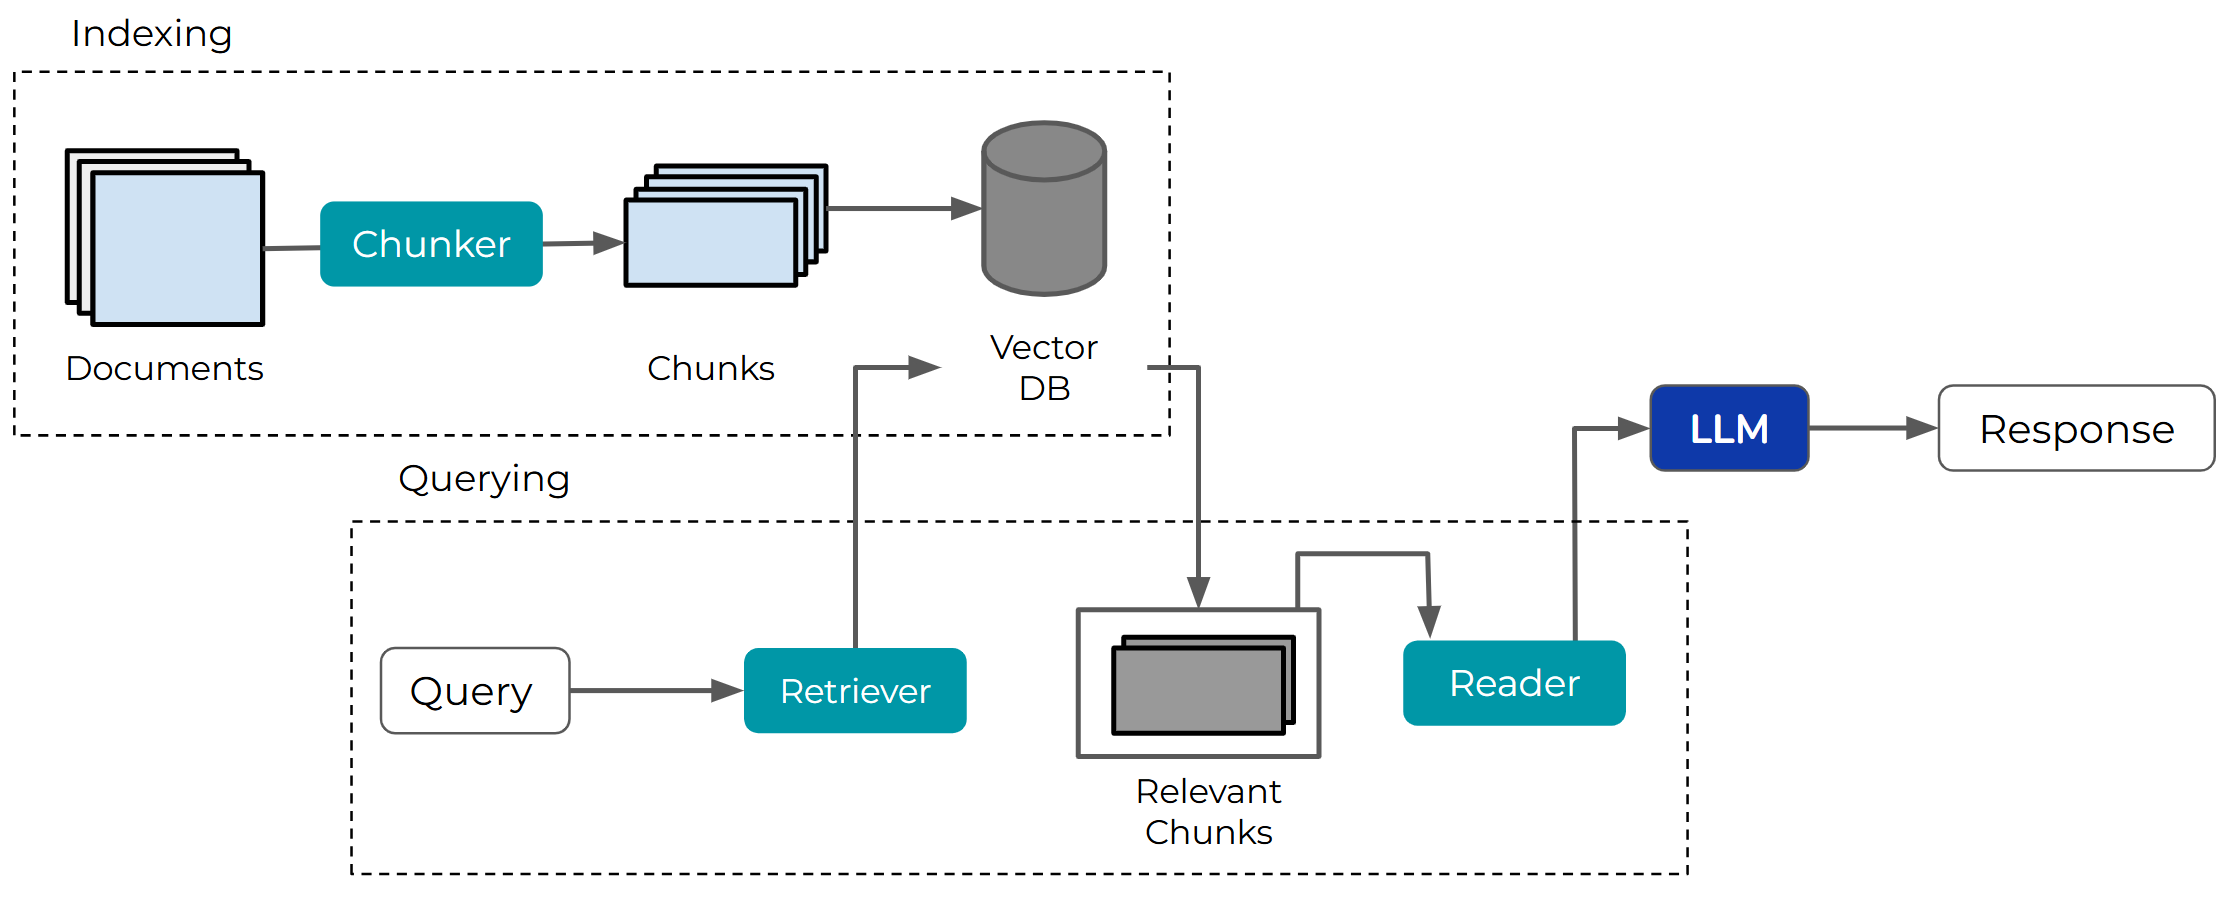

**Workflow Overview:**

To build this HR Policy RAG Assistant, we will follow these steps:
1. Load the HR manual PDF(s) by uploading them into Colab or loading from Google Drive.
2. Extract and chunk the text using a token-aware splitter designed to preserve context across sections.
3. Embed and store the chunks in a persistent Chroma vector database using the Gemini embedding model.
4. Build a retriever that identifies the most relevant policy chunks for any employee query.
5. Construct a grounded RAG prompt that provides the retrieved chunks as context to Gemini.
6. Generate the final answer, ensuring it is factual, concise, and derived only from the provided HR policies.
7. (Optional) Display source chunk IDs for transparency and auditing.

This results in an end-to-end RAG pipeline capable of answering HR policy questions accurately and consistently.

## 3.1 Load HR Manual PDF(s) and split into token-aware chunks

In this step, we load the HR Policy Manual PDF(s), extract the raw text, and break it into token-aware, overlapping chunks. Since LLMs cannot process long documents in a single prompt, chunking ensures that each portion of the policy is small enough for retrieval while still preserving context across sections.

You may load the HR Manual in two ways:

1. **OPTION A:** Load directly from Google Drive  
2. **OPTION B (Recommended):** Manually upload the PDF into Colab and read it from `/content`  

For this case study, **we will use Option B**.


In [ ]:
# -------------------------------
# OPTION A (optional): Load PDFs from Google Drive
# -------------------------------
# (Commented out by default - use only if the PDF(s) already live in Drive.)
#
# from google.colab import drive
# drive.mount('/content/drive')
# PDF_PATH_OR_FOLDER = "/content/drive/MyDrive/HR_Policies"  # <-- CHANGE THIS to folder or single file path



# -------------------------------
# OPTION B (recommended): Manual upload into Colab (read from /content)
# -------------------------------
# 1) In Colab left sidebar -> Files -> Upload, choose your PDF file(s) (e.g., HR_Manual.pdf)
# 2) Uploaded files appear under /content
# 3) Update the PDF_PATH_OR_FOLDER below if your filename is different

PDF_PATH_OR_FOLDER = "/content/HR_Manual.pdf"   # <-- CHANGE if you uploaded a different name

# If you uploaded an entire folder of PDFs, set PDF_PATH_OR_FOLDER = "/content/your_folder" and ensure it is a folder

In [ ]:
from pypdf import PdfReader

# Detect whether the path is a folder (multiple PDFs) or a single file
is_folder = os.path.isdir(PDF_PATH_OR_FOLDER)

# Token-aware text splitter (uses the OpenAI/GPT tokenizer encoding for accurate token counts)
# Adjust chunk_size / chunk_overlap to suit your tradeoff between context and number of chunks
CHUNK_SIZE = 800
CHUNK_OVERLAP = 128

if is_folder:
    # Folder case: use PyPDFDirectoryLoader to load all PDFs and split using the splitter
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP
    )

    pdf_loader = PyPDFDirectoryLoader(PDF_PATH_OR_FOLDER)
    docs = pdf_loader.load_and_split(text_splitter)

else:
    # Single file case: extract text using pypdf then split with the same token-aware splitter
    reader = PdfReader(PDF_PATH_OR_FOLDER)
    pages = []
    for p in reader.pages:
        pages.append(p.extract_text() or "")

    full_text = "\n\n".join(pages)

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP
    )

    # create_documents returns a list of langchain Document objects
    docs = text_splitter.create_documents([full_text])

In [ ]:
# Quick stats & preview
print("Number of chunks/documents created:", len(docs))
print("\n--- First chunk preview (first 1000 chars) ---\n")
if len(docs) > 0:
    preview = docs[0].page_content[:1000]
    print(preview)
else:
    print("No document chunks found. Check PDF_PATH_OR_FOLDER and that the file contains extractable text.")

Number of chunks/documents created: 27

--- First chunk preview (first 1000 chars) ---

HR Manual / Employee Handbook             Doctors For You - HR Manual / Employee Handbook (Updated 2025) Prepared in 2013, edited 2017, 2019, 2023, 2025 


Content  1 Introduction 1.1 Statement of Philosophy 1.2 Who we are 1.3 Vision & Mission 2 Policies 3 Employment at Doctors For You 4 Your Holidays and Leaves 5 Termination 6 Vacation Time and Vacation Pay 7 Benefits 8 Resolution 9 Committees 10 Appendix 1- Guidance for taking leaves 

Article 1. Introduction  This employee handbook is a summary of policies, procedures and practices related to human resource management at Doctors for You. The Board of Directors is accountable for leading an effective team and is thereby concerned about the development and implementation of the policies outlined in this manual. This manual shall act as a reference to the Managers in their endeavour to implement human resource management within their own teams and w

## 3.2 Create a persistent Chroma collection and populate it with embeddings


> After preparing the chunked HR policy documents, the next step is to convert each chunk into an embedding—a numerical vector representing its semantic meaning. We then store these embeddings in a **persistent Chroma vector database**, which becomes the knowledge base for our RAG system.  

> By saving the vector index in a **persistent directory on Google Drive**, we ensure that the database survives across Colab sessions (unlike `/content`, which is temporary). This allows us to reuse the vectorstore later without having to recompute embeddings each time, saving both time and API usage.

> Once stored, the vector database can efficiently retrieve the most relevant policy chunks whenever the user asks a question.


In [ ]:
# Configure persistent DB directory (use Drive path if you want persistence across sessions)
PERSIST_DIR = "/content/drive/MyDrive/rag_chroma_db"  # <-- change if you want a different location
COLLECTION_NAME = "hr_policy_manual"

In [ ]:
# 1) Create or open a persistent Chroma client
chromadb_client = chromadb.PersistentClient(path=PERSIST_DIR)

In [ ]:
# 2) Create (or get) the collection
# If the collection exists, we get it; otherwise create it.
existing_collections = [c for c in chromadb_client.list_collections()]
if COLLECTION_NAME in existing_collections:
    collection = chromadb_client.get_collection(COLLECTION_NAME)
else:
    # create collection without embeddings initially
    collection = chromadb_client.create_collection(name=COLLECTION_NAME, metadata={"hnsw:space": "cosine"})

print("Chroma collection ready:", COLLECTION_NAME)

Chroma collection ready: hr_policy_manual


In [ ]:
# 3) Prepare data to add: ids, documents (texts), metadatas
texts = [d.page_content for d in docs]

# Fix: Pass metadatas=None if no meaningful metadata exists, otherwise ensure dicts are non-empty.
# Since `docs` here don't have inherent metadata from the PDF extraction,
# passing None is appropriate.
metadatas_to_add = None # [getattr(d, "metadata", {}) or {} for d in docs]
ids = [f"doc_{i}" for i in range(len(texts))]

In [ ]:
# 4) Create embeddings in batches using Gemini embedding model via OpenAI-compatible client
#    Model: "gemini-embedding-001"
BATCH = 64  # batch size for embedding calls (adjust to manage memory/rate)
all_embeddings = []

for i in tqdm(range(0, len(texts), BATCH), desc="Embedding batches"):
    batch_texts = texts[i : i + BATCH]
    # client.embeddings.create supports list input
    emb_resp = client.embeddings.create(
        model="gemini-embedding-001",
        input=batch_texts
    )
    batch_emb = [r.embedding for r in emb_resp.data]
    all_embeddings.extend(batch_emb)

print("Total embeddings produced:", len(all_embeddings))

Embedding batches: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Total embeddings produced: 27


In [ ]:
# 5) Add (or upsert) embeddings to Chroma collection
# If collection already had content and you want to avoid duplicates, you might want to delete first; here we add.
collection.add(
    ids=ids,
    documents=texts,
    metadatas=metadatas_to_add, # Use the corrected variable
    embeddings=all_embeddings
)

In [ ]:
# 6) Persist to disk (Chroma PersistentClient already writes to path)
print("Indexed", collection.count(), "chunks into Chroma collection:", COLLECTION_NAME)


Indexed 27 chunks into Chroma collection: hr_policy_manual


## 3.3 Build Retriever and RAG Answer Function

> With the vectorstore ready, we build a retriever that identifies the most relevant policy chunks for any given user query by comparing embeddings. These retrieved chunks are then inserted into a structured RAG prompt, along with the user’s question, and passed to the Gemini model to generate a grounded, policy-accurate answer. The final `answer_question()` function ties everything together, performing retrieval and generation in one call to power the HR Policy Assistant.

In [ ]:
# Parameters
EMBED_MODEL = "gemini-embedding-001"
GEN_MODEL = "gemini-2.5-flash"   # model used for generation (chat)
K_DEFAULT = 4                   # default number of chunks to retrieve

In [ ]:
#Helper Functions

# Helper: embed a query
def embed_query(text: str):
    resp = client.embeddings.create(model=EMBED_MODEL, input=[text])
    return resp.data[0].embedding

# Helper: retrieve top-k chunks from Chroma using the query embedding
# We'll use the collection.query method which accepts embedded vectors
def retrieve_top_k(query: str, k: int = K_DEFAULT):
    q_emb = embed_query(query)
    # Chromadb query by embedding returns matching ids/documents/metadatas
    results = collection.query(
        query_embeddings=[q_emb],
        n_results=k,
        include=["documents", "metadatas", "distances"]
    )
    # results is a dict: keys like 'ids', 'documents', each value is list-of-lists (for batch queries)
    ids = results["ids"][0]
    docs_text = results["documents"][0]
    metadatas = results["metadatas"][0]
    distances = results.get("distances", [[]])[0]
    return [{"id": _id, "text": t, "metadata": m, "score": float(distances[idx]) if distances else None}
            for idx, (_id, t, m) in enumerate(zip(ids, docs_text, metadatas))]


In [ ]:
# System message and prompt template for RAG generation
RAG_SYSTEM_MESSAGE = """
You are an assistant that answers employee HR policy questions using ONLY the provided context.
Context will be provided between <Context> and </Context>.
If the answer is not contained in the context, respond exactly with: "I don't know".
Do not hallucinate. Provide concise, policy-grounded answers.
"""

RAG_USER_TEMPLATE = """
<Context>
{context}
</Context>

<Question>
{question}
</Question>
"""

In [ ]:
# Main function: answer_question
def answer_question(question: str, k: int = K_DEFAULT, model_name: str = GEN_MODEL):
    # 1) Retrieve top-k relevant chunks
    retrieved = retrieve_top_k(question, k=k)
    # 2) Build context string (join the chunk texts and optionally include ids/metadata)
    context_items = []
    for r in retrieved:
        # include an id header so we can cite back later if needed
        header = f"[{r['id']}]"
        context_items.append(header + " " + r["text"])
    context_str = "\n\n---\n\n".join(context_items)

    # 3) Build messages and call the chat completion
    prompt_messages = [
        {"role": "system", "content": RAG_SYSTEM_MESSAGE},
        {"role": "user", "content": RAG_USER_TEMPLATE.format(context=context_str, question=question)}
    ]

    response = client.chat.completions.create(
        model=model_name,
        messages=prompt_messages,
        temperature=0.0,
        max_tokens=512
    )
    answer_text = response.choices[0].message.content.strip()

    # 4) Return the answer and the retrieved chunk ids (for citation)
    retrieved_ids = [r["id"] for r in retrieved]
    return answer_text, retrieved_ids, retrieved

In [ ]:
# Quick demo query (replace with your own policy question)
demo_q = "How many days of paid maternity leave are permanent employees entitled to?"
ans, src_ids, details = answer_question(demo_q, k=4)
print("Answer:\n", ans)
print("\nSources used:", src_ids)

Answer:
 Regular salaried employees are entitled to up to 26 weeks of paid maternity leave. However, a woman who already has two or more children is entitled to 12 weeks of maternity leave. The maternity leave with full pay is granted on completion of at least 80 days in an establishment in the 12 months prior to her expected date of delivery.

Sources used: ['doc_10', 'doc_9', 'doc_8', 'doc_25']


# Conclusion


In this notebook, we explored three practical business applications of Generative AI using Gemini models—text classification, text summarization, and Retrieval-Augmented Generation (RAG). We began by setting up the environment, preparing our Gemini API access, and installing all required libraries. Through the first two case studies, we demonstrated how LLMs can classify hotel guest reviews into meaningful categories and transform clinical visit notes into simple, patient-friendly summaries using structured few-shot prompting.  

In the final case study, we built an end-to-end RAG pipeline that converts unstructured HR policy documents into a searchable knowledge base using Chroma vector storage and Gemini embeddings. This enabled accurate, grounded answers for employee HR queries, showcasing how organizations can modernize internal communication and reduce repetitive manual workloads. Together, these case studies highlight how LLMs and RAG systems can be combined to build practical, scalable AI solutions across industries.